[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab0-ML/notebooks/03-PyCaret_hurtigguide.ipynb)

# PyCaret: Hurtigguide for medisinsk maskinlæring

**Automatisert maskinlæring (AutoML) for klinisk forskning**

---

## Hva er PyCaret?

PyCaret er et høynivå Python-bibliotek som automatiserer store deler av maskinlæringsarbeidsflyten:

| Tradisjonell ML | PyCaret |
|----------------|---------|
| 50+ linjer kode | 5 linjer kode |
| Manuelt modellvalg | Automatisk sammenligning av 15+ modeller |
| Manuell hyperparameter-tuning | Innebygd `tune_model()` |
| Egen visualiseringskode | `plot_model()` for alt |

---

## ⚠️ Viktig advarsel før du starter

> **Forstå grunnlaget først!**
>
> PyCaret gjør maskinlæring *enkelt* – kanskje for enkelt. Før du bruker dette verktøyet, bør du ha gjennomført:
> - `01-Enkle_eksempler.ipynb` – Grunnleggende ML-konsepter
> - `02-Binaer_klassifikasjon.ipynb` – Evaluering, metrikker, validering
>
> Uten denne forståelsen risikerer du å:
> - Overtilpasse modellen til treningsdata
> - Misforstå hva metrikkene faktisk betyr
> - Publisere resultater som ikke generaliserer

---

**Versjon:** November 2025  
**Forfatter:** Basert på original av A.S. Lundervold, utvidet med medisinsk kontekst

---

## Når bør du bruke PyCaret?

### ✅ Gode bruksområder

| Scenario | Hvorfor PyCaret er nyttig |
|----------|---------------------------|
| **Eksplorativ analyse** | Raskt se hvilke modeller som fungerer på datasettet |
| **Prototyping** | Teste en idé før du investerer tid i manuell koding |
| **Baseline-modeller** | Etablere en "best effort" å sammenligne mot |
| **Undervisning** | Demonstrere ML-konsepter uten mye kode |

### ❌ Når du IKKE bør stole blindt på PyCaret

| Scenario | Problem |
|----------|---------|
| **Klinisk implementering** | Krever grundig validering og tolkbarhet |
| **Publisering** | Må dokumentere *hvorfor* denne modellen ble valgt |
| **Regulatorisk godkjenning** | FDA/CE krever full transparens |
| **Små datasett** | Risiko for overfitting ved automatisk modellvalg |

---

> 🏥 **Klinisk perspektiv:** PyCaret kan være et godt *utgangspunkt*, men aldri et *endepunkt* for medisinsk AI-utvikling.

---

## Installasjon og oppsett

### Alternativ 1: Google Colab (anbefalt for denne notebooken)

Colab har de fleste avhengigheter, men PyCaret må installeres:

In [3]:
# Sjekk om vi kjører i Colab
try:
    import google.colab
    IN_COLAB = True
    print("Kjører i Google Colab")
except:
    IN_COLAB = False
    print("Kjører IKKE i Colab")


Kjører IKKE i Colab


In [4]:
# Installer PyCaret hvis i Colab
if IN_COLAB:
    print("Installerer PyCaret... (dette kan ta 1-2 minutter)")
    %pip install pycaret[full] -q
    print("Ferdig!")

### Alternativ 2: Lokalt miljø

PyCaret har mange avhengigheter som kan konflikte med andre pakker. Vi anbefaler et **separat conda-miljø**:

```bash
# Opprett eget miljø for PyCaret
conda create -n pycaret-env python=3.10 -y
conda activate pycaret-env

# Installer PyCaret
pip install pycaret[full]

# Start Jupyter
jupyter notebook
```

> ⚠️ **Merk:** PyCaret kan komme i konflikt med TensorFlow/PyTorch-versjoner i hovedmiljøet. Derfor anbefaler vi separat miljø.

---

## Importer biblioteker

In [7]:
# Undertrykk advarsler for renere output
import warnings
warnings.filterwarnings('ignore')

# Grunnleggende biblioteker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyCaret
import pycaret
from pycaret.classification import *

print("Biblioteker lastet!")
print(f"PyCaret versjon: {pycaret.__version__}")

Biblioteker lastet!
PyCaret versjon: 3.3.2


---

## Last inn data: Diabetes-datasettet

Vi bruker det samme diabetes-datasettet som i de foregående notebookene. Dette gir konsistens og lar deg sammenligne resultater.

In [8]:
# Last inn diabetes-data (samme som i 02-Binaer_klassifikasjon.ipynb)
url = 'https://assets.datacamp.com/production/course_1939/datasets/diabetes.csv'
diabetes = pd.read_csv(url)

print(f"Datasett lastet: {len(diabetes)} pasienter, {len(diabetes.columns)} variabler")
print(f"\nKlassefordeling:")
print(diabetes['diabetes'].value_counts())

Datasett lastet: 768 pasienter, 9 variabler

Klassefordeling:
diabetes
0    500
1    268
Name: count, dtype: int64


In [9]:
# Vis de første radene
diabetes.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


---

## Steg 1: Sett opp eksperimentet med `setup()`

`setup()` er den viktigste funksjonen i PyCaret. Den:
- Identifiserer variabeltyper automatisk
- Deler data i trenings- og testsett
- Håndterer manglende verdier
- Skalerer numeriske variabler
- Konfigurerer kryssvalidering

### Hva skjer "under panseret"?

| Parameter | Hva den gjør | Standard |
|-----------|--------------|----------|
| `target` | Kolonnen vi predikerer | Må spesifiseres |
| `train_size` | Andel til trening | 0.7 (70%) |
| `normalize` | Skalerer numeriske variabler | False |
| `fold` | Antall folds i kryssvalidering | 10 |
| `session_id` | Seed for reproduserbarhet | Tilfeldig |

In [10]:
# Sett opp PyCaret-eksperiment
# session_id=42 sikrer reproduserbare resultater

experiment = setup(
    data=diabetes,              # Vårt datasett
    target='diabetes',          # Kolonnen vi predikerer (0/1)
    train_size=0.75,            # 75% trening, 25% test (som i notebook 02)
    normalize=True,             # Skaler data (viktig for mange modeller)
    normalize_method='zscore',  # StandardScaler-ekvivalent
    fold=5,                     # 5-fold kryssvalidering
    session_id=42,              # For reproduserbarhet
    verbose=False               # Mindre output
)

print("Eksperiment konfigurert!")

Eksperiment konfigurert!


In [15]:
# Gi informasjon om det oppsatte eksperimentet
# I PyCaret 3.x bruker vi get_config() for å hente data

X_train = get_config('X_train')
X_test = get_config('X_test')
y_train = get_config('y_train')
y_test = get_config('y_test')

print(f"Antall variabler (features): {X_train.shape[1]}")
print(f"Observasjoner i treningssettet: {len(X_train)}")
print(f"Observasjoner i testsettet: {len(X_test)}")
print(f"Totalt: {len(X_train) + len(X_test)} observasjoner")
print(f"\nKlassefordeling i trening:")
print(y_train.value_counts())


Antall variabler (features): 8
Observasjoner i treningssettet: 576
Observasjoner i testsettet: 192
Totalt: 768 observasjoner

Klassefordeling i trening:
diabetes
0    375
1    201
Name: count, dtype: int64


In [19]:
# Annen informasjon om eksperimentet (PyCaret 3.x syntaks)
# Hent fold-generator for å finne antall folds
fold_gen = get_config('fold_generator')

print(f"\nEksperiment-konfigurasjon:")
print(f"Antall observasjoner: {len(X_train) + len(X_test)}")
print(f"Antall variabler: {X_train.shape[1]}")
print(f"Antall folds: {fold_gen.n_splits}")
print(f"Session ID (seed): {get_config('seed')}")



Eksperiment-konfigurasjon:
Antall observasjoner: 768
Antall variabler: 8
Antall folds: 5
Session ID (seed): 42


### Forstå output fra `setup()`

PyCaret viser en oppsummering av datasettet og konfigurasjon. Legg merke til:
- **Antall observasjoner** i trening og test
- **Antall numeriske/kategoriske variabler**
- **Preprosesseringssteg** som ble utført

> 🤔 **Refleksjon:** Hvordan samsvarer dette med oppdelingen vi gjorde manuelt i `02-Binaer_klassifikasjon.ipynb`?

---

## Steg 2: Sammenlign modeller med `compare_models()`

Dette er PyCaret sin "killer feature" – én linje kode som:
1. Trener 15+ forskjellige modeller
2. Evaluerer hver med kryssvalidering
3. Rangerer dem etter valgt metrikk

### Hvilke modeller sammenlignes?

In [20]:
# Vis alle tilgjengelige modeller
tilgjengelige = models()
print(f"PyCaret kan sammenligne {len(tilgjengelige)} modeller automatisk!")
tilgjengelige

PyCaret kan sammenligne 19 modeller automatisk!


,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### Forklaring av de 19 modellene

<details>
<summary>🔍 <strong>Klikk for å se beskrivelse av alle modeller</strong></summary>

#### Lineære modeller (enkle, tolkbare)

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `lr` | **Logistic Regression** | Klassisk statistisk metode. Modellerer sannsynlighet med sigmoid-funksjon. | ⭐⭐⭐ Høy |
| `ridge` | **Ridge Classifier** | Logistisk regresjon med L2-regularisering (straffer store koeffisienter). | ⭐⭐⭐ Høy |
| `lda` | **Linear Discriminant Analysis** | Finner lineær kombinasjon som best separerer klassene. Antar normalfordelte data. | ⭐⭐⭐ Høy |
| `qda` | **Quadratic Discriminant Analysis** | Som LDA, men tillater ulik varians per klasse. Mer fleksibel. | ⭐⭐ Middels |

#### Probabilistiske modeller

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `nb` | **Naive Bayes** | Antar at alle variabler er uavhengige (naivt!). Rask, fungerer ofte overraskende bra. | ⭐⭐⭐ Høy |
| `gpc` | **Gaussian Process Classifier** | Bayesiansk metode med usikkerhetsestimater. *Treg på store datasett.* | ⭐⭐ Middels |

#### Instansbaserte modeller

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `knn` | **K-Nearest Neighbors** | Klassifiserer basert på de K nærmeste naboene. Ingen trening, alt skjer ved prediksjon. | ⭐⭐ Middels |

#### Support Vector Machines

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `svm` | **SVM - Linear Kernel** | Finner optimal hyperplan som separerer klassene. Effektiv for høydimensjonale data. | ⭐⭐ Middels |
| `rbfsvm` | **SVM - RBF Kernel** | SVM med radial basis function. Kan håndtere ikke-lineære grenser. | ⭐ Lav |

#### Trebaserte modeller (ofte best ytelse)

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `dt` | **Decision Tree** | Lager if-then-else regler. Lett å visualisere og forklare. | ⭐⭐⭐ Høy |
| `rf` | **Random Forest** | Ensemble av mange beslutningstrær. Robust, håndterer overfitting godt. | ⭐⭐ Middels |
| `et` | **Extra Trees** | Som Random Forest, men enda mer tilfeldig splitting. Ofte raskere. | ⭐⭐ Middels |

#### Boosting-modeller (ofte topp-ytelse)

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `ada` | **AdaBoost** | Kombinerer svake modeller sekvensielt. Fokuserer på feil fra forrige runde. | ⭐ Lav |
| `gbc` | **Gradient Boosting** | Bygger trær sekvensielt for å minimere feil. Kraftig, men kan overtilpasse. | ⭐ Lav |
| `xgboost` | **XGBoost** | Optimalisert gradient boosting. Ofte vinner i konkurranser. *Krever egen installasjon.* | ⭐ Lav |
| `lightgbm` | **LightGBM** | Rask gradient boosting fra Microsoft. Effektiv på store datasett. | ⭐ Lav |
| `catboost` | **CatBoost** | Gradient boosting fra Yandex. Håndterer kategoriske variabler automatisk. | ⭐ Lav |

#### Nevrale nettverk

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `mlp` | **Multi-layer Perceptron** | Enkelt nevralt nettverk. Fleksibel, men *treg å trene*. | ⭐ Lav |

#### Referansemodell

| ID | Modell | Beskrivelse | Tolkbarhet |
|----|--------|-------------|------------|
| `dummy` | **Dummy Classifier** | Gjetter basert på klassefordeling. Brukes som baseline – alle modeller bør slå denne! | N/A |

---

### Hva betyr "Turbo"?

`compare_models()` har en parameter `turbo=True` (standard). Når Turbo er aktivert:

| Modell | Turbo=True | Turbo=False |
|--------|-----------|-------------|
| `gpc` (Gaussian Process) | ❌ Ekskludert | ✅ Inkludert |
| `mlp` (Neural Network) | ❌ Ekskludert | ✅ Inkludert |
| Andre modeller | ✅ Inkludert | ✅ Inkludert |

**Hvorfor?** Gaussian Process og MLP er *betydelig tregere* enn de andre modellene, spesielt på større datasett. Turbo-modus gir raskere sammenligning på bekostning av å utelate disse to.

```python
# Inkluder alle modeller (tregere, men komplett)
beste = compare_models(turbo=False)
```

---

### Anbefaling for medisinsk bruk

| Prioritet | Modeller | Begrunnelse |
|-----------|----------|-------------|
| **Høy tolkbarhet** | `lr`, `dt`, `nb` | Lett å forklare til pasienter og kollegaer |
| **Beste ytelse** | `rf`, `lightgbm`, `catboost` | Ofte topp-scorer, men "black box" |
| **Usikkerhetsestimater** | `gpc`, kalibrert `lr` | Viktig for klinisk beslutningstaking |

> 🏥 **Klinisk tips:** For medisinsk AI er tolkbarhet ofte viktigere enn maksimal AUC. En enkel logistisk regresjon som leger kan forstå, kan være bedre enn en kompleks modell de ikke stoler på.

</details>


In [33]:
%%time
# Sammenlign modeller og velg de 5 beste basert på AUC
# Dette tar typisk 1-3 minutter avhengig av datasett

print("Trener og sammenligner modeller... (dette kan ta litt tid)")
print("-" * 50)

beste_modeller = compare_models(
    n_select=5,           # Velg de 5 beste
    sort='AUC',           # Ranger etter AUC (viktig for medisin!)
    fold=5,               # 5-fold kryssvalidering
    verbose=True          # Vis fremgang
)

# VIKTIG: Lagre sammenlignings-tabellen UMIDDELBART etter compare_models()!
# pull() returnerer kun resultatet fra siste PyCaret-operasjon
sammenligning_cv = pull()

print("-" * 50)
print("Ferdig!")

Trener og sammenligner modeller... (dette kan ta litt tid)
--------------------------------------------------


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7796,0.8223,0.5918,0.7326,0.6518,0.4934,0.5016,2.3980
lda,Linear Discriminant Analysis,0.7847,0.8217,0.5968,0.7411,0.6590,0.5045,0.5125,0.0060
catboost,CatBoost Classifier,0.7588,0.8217,0.5671,0.6960,0.6211,0.4472,0.4550,0.4820
ridge,Ridge Classifier,0.7865,0.8216,0.5868,0.7521,0.6564,0.5053,0.5154,0.0060
qda,Quadratic Discriminant Analysis,0.7639,0.8209,0.6120,0.6841,0.6437,0.4683,0.4717,0.4260
nb,Naive Bayes,0.7604,0.8207,0.5920,0.6901,0.6326,0.4569,0.4635,0.0060
et,Extra Trees Classifier,0.7639,0.8190,0.5722,0.7059,0.6272,0.4579,0.4667,0.0220
rf,Random Forest Classifier,0.7553,0.8155,0.5868,0.6794,0.6242,0.4453,0.4516,0.4460
gbc,Gradient Boosting Classifier,0.7465,0.8030,0.5620,0.6651,0.6053,0.4214,0.4273,0.0180
ada,Ada Boost Classifier,0.7397,0.7836,0.5270,0.6681,0.5818,0.3983,0.4087,0.0120


--------------------------------------------------
Ferdig!
CPU times: user 2.83 s, sys: 3.27 s, total: 6.11 s
Wall time: 29 s


In [40]:
# Vis sammenlignings-tabellen (5-fold CV på treningsdata)
print("Kryssvaliderings-resultater for alle modeller:")
print("(Gjennomsnitt av 5 folds på 576 treningspasienter)")
print()
sammenligning_cv


Kryssvaliderings-resultater for alle modeller:
(Gjennomsnitt av 5 folds på 576 treningspasienter)



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7796,0.8223,0.5918,0.7326,0.6518,0.4934,0.5016,2.398
lda,Linear Discriminant Analysis,0.7847,0.8217,0.5968,0.7411,0.6590,0.5045,0.5125,0.006
catboost,CatBoost Classifier,0.7588,0.8217,0.5671,0.6960,0.6211,0.4472,0.4550,0.482
ridge,Ridge Classifier,0.7865,0.8216,0.5868,0.7521,0.6564,0.5053,0.5154,0.006
qda,Quadratic Discriminant Analysis,0.7639,0.8209,0.6120,0.6841,0.6437,0.4683,0.4717,0.426
nb,Naive Bayes,0.7604,0.8207,0.5920,0.6901,0.6326,0.4569,0.4635,0.006
et,Extra Trees Classifier,0.7639,0.8190,0.5722,0.7059,0.6272,0.4579,0.4667,0.022
rf,Random Forest Classifier,0.7553,0.8155,0.5868,0.6794,0.6242,0.4453,0.4516,0.446
gbc,Gradient Boosting Classifier,0.7465,0.8030,0.5620,0.6651,0.6053,0.4214,0.4273,0.018
ada,Ada Boost Classifier,0.7397,0.7836,0.5270,0.6681,0.5818,0.3983,0.4087,0.012


### Evaluering på hold-out testdata

Tabellen over viser kryssvaliderings-resultater fra `compare_models()`. Disse er beregnet på **treningsdata** (576 pasienter) ved å rotere gjennom 5 folds.

**Nå skal vi gjøre noe viktig:** Evaluere de 5 beste modellene på **testdata** som har vært holdt helt utenfor!

```
┌─────────────────────────────────────────────────────────────────┐
│  TRENINGSDATA (576 pasienter)                                   │
│  ├── Brukt til compare_models() med 5-fold CV                   │
│  └── Modellene er trent på dette                                │
└─────────────────────────────────────────────────────────────────┘
                              ↓
           De 5 beste modellene fra CV er valgt
                              ↓
┌─────────────────────────────────────────────────────────────────┐
│  TESTDATA (192 pasienter) - ALDRI SETT FØR!                     │
│  ├── Holdt ut ved setup(train_size=0.75)                        │
│  └── Gir "ekte" estimat på nye pasienter                        │
└─────────────────────────────────────────────────────────────────┘
```

**Hvorfor er dette viktig?**
- CV-score kan være **optimistisk** fordi modellvalg skjedde basert på CV
- Testdata gir et mer **realistisk** estimat av ytelse i klinikken
- Hvis test-score er mye lavere enn CV-score → tegn på overtilpasning

> 🏥 **Klinisk relevans:** Dette tilsvarer å utvikle en diagnostisk modell på pasienter fra 2020-2022, og deretter teste den på nye pasienter fra 2023.


In [41]:
# Gi en beskrivelse av resultatene og hvilke modeller som ble valgt
# I PyCaret 3.x bruker vi predict_model() for å evaluere på testdata
# Resultatene lagres som en DataFrame

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

print(f"Valgte modeller: {[type(m).__name__ for m in beste_modeller]}")
print(f"\nBeregner ytelse på hold-out testdata (25% = 192 pasienter)...")

# Samle resultater i en liste
resultater = []

for m in beste_modeller:
    # predict_model() bruker automatisk testsettet fra setup()
    pred = predict_model(m, verbose=False)
    y_true = pred['diabetes']
    y_pred = pred['prediction_label']
    
    acc = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Prøv først prediction_score (fra predict_proba)
    # Hvis det feiler (f.eks. RidgeClassifier), prøv decision_function
    auc_kilde = "predict_proba"
    try:
        if 'prediction_score' in pred.columns:
            auc = roc_auc_score(y_true, pred['prediction_score'])
        else:
            # Fallback: bruk decision_function direkte
            X_test = get_config('X_test')
            scores = m.decision_function(X_test)
            auc = roc_auc_score(y_true, scores)
            auc_kilde = "decision_function"
    except Exception as e:
        auc = None
        auc_kilde = "N/A"
    
    resultater.append({
        'Modell': type(m).__name__,
        'Accuracy': acc,
        'AUC': auc,
        'Recall': recall,
        'Precision': prec,
        'F1': f1,
        'AUC_kilde': auc_kilde
    })

# Lag DataFrame
testdata_ytelse = pd.DataFrame(resultater)
testdata_ytelse = testdata_ytelse.set_index('Modell')

print("Ferdig!\n")
testdata_ytelse


Valgte modeller: ['LogisticRegression', 'LinearDiscriminantAnalysis', 'CatBoostClassifier', 'RidgeClassifier', 'QuadraticDiscriminantAnalysis']

Beregner ytelse på hold-out testdata (25% = 192 pasienter)...
Ferdig!



,Accuracy,AUC,Recall,Precision,F1,AUC_kilde
Modell,,,,,,
LogisticRegression,0.734375,0.305672,0.522388,0.648148,0.578512,predict_proba
LinearDiscriminantAnalysis,0.734375,0.308060,0.522388,0.648148,0.578512,predict_proba
CatBoostClassifier,0.750000,0.300657,0.597015,0.655738,0.625000,predict_proba
RidgeClassifier,0.729167,0.804179,0.507463,0.641509,0.566667,decision_function
QuadraticDiscriminantAnalysis,0.687500,0.461194,0.567164,0.550725,0.558824,predict_proba


### Hvordan beregnes metrikkene? Kryssvalidering vs. testdata

PyCaret bruker **to forskjellige evalueringsstrategier** – det er viktig å forstå forskjellen:

---

#### 1️⃣ Tabellen fra `compare_models()`: K-fold kryssvalidering på TRENINGSDATA

```
┌─────────────────────────────────────────────────────────────┐
│                    ORIGINALT DATASETT                       │
│                      (768 pasienter)                        │
└─────────────────────────────────────────────────────────────┘
                            │
            ┌───────────────┴───────────────┐
            ▼                               ▼
    ┌───────────────┐               ┌───────────────┐
    │  TRENINGSDATA │               │   TESTDATA    │
    │   (75% = 576) │               │  (25% = 192)  │
    │               │               │               │
    │  Brukes til   │               │  HOLDES HELT  │
    │  compare_     │               │  UTENFOR til  │
    │  models()     │               │  slutt!       │
    └───────────────┘               └───────────────┘
            │
            ▼
    ┌─────────────────────────────────────────┐
    │     5-FOLD KRYSSVALIDERING              │
    │                                         │
    │  Fold 1: [Val] [Trn] [Trn] [Trn] [Trn]  │
    │  Fold 2: [Trn] [Val] [Trn] [Trn] [Trn]  │
    │  Fold 3: [Trn] [Trn] [Val] [Trn] [Trn]  │
    │  Fold 4: [Trn] [Trn] [Trn] [Val] [Trn]  │
    │  Fold 5: [Trn] [Trn] [Trn] [Trn] [Val]  │
    │                                         │
    │  → Gjennomsnitt av 5 fold = CV-score    │
    └─────────────────────────────────────────┘
```

**Tallene i `compare_models()`-tabellen er:**
- Gjennomsnitt av 5 kryssvalideringsfold
- Kun beregnet på **treningsdata** (576 pasienter)
- Gir robust estimat, men kan være optimistisk pga. modellvalg

---

#### 2️⃣ Tabellen over (vår `predict_model()`): Hold-out TESTDATA

**Tallene i tabellen vi nettopp laget er:**
- Beregnet på de **192 pasientene** som ble holdt ut ved `setup()`
- Disse dataene har modellen **aldri sett** under trening
- Gir mer realistisk estimat av ytelse på nye pasienter

---

#### Hvorfor kan tallene være forskjellige?

| Situasjon | CV-score vs. Test-score |
|-----------|-------------------------|
| **CV > Test** | Vanlig! Modellvalg basert på CV kan gi overtilpasning |
| **CV ≈ Test** | Bra! Modellen generaliserer godt |
| **CV < Test** | Uvanlig – kan skyldes tilfeldigheter i liten test-split |

---

#### ⚠️ Viktig for medisinsk forskning

> **Problemet med PyCaret:**
> Når du kjører `compare_models()` og velger "beste modell" basert på CV-score, har du indirekte brukt treningsdata til modellvalg. Den etterfølgende evalueringen på testdata er derfor **ikke helt uavhengig**.
>
> **Løsning for publisering:**
> - Bruk ekstern validering (data fra annet sykehus/tidsperiode)
> - Eller: Nested cross-validation (mer komplekst)
> - Rapporter alltid begge tall (CV og hold-out test)


<details>
<summary>🔍 <strong>Dypdykk: Hvorfor er ikke testdata helt uavhengig?</strong></summary>

### Problemet: Indirekte datalekkasje ved modellvalg

Selv om testdata aldri brukes til å **trene** modellene, brukes de indirekte når du **velger** hvilken modell som er best.

#### Scenario: Tenk deg følgende

```
Du har 17 modeller og tester alle på det samme testsettet.
En av dem får AUC = 0.85 bare ved tilfeldighet (flaks).
Du velger denne modellen fordi den "vant" på testdata.
→ Du har nå valgt en modell som er overtilpasset til testsettet!
```

#### Illustrasjon av problemet

```
┌─────────────────────────────────────────────────────────────────────────┐
│                         IDEELT SCENARIO                                 │
│                                                                         │
│  Treningsdata ──→ Tren ALLE modeller                                    │
│                          │                                              │
│                          ↓                                              │
│  Valideringsdata ──→ Velg BESTE modell  (basert på validering)          │
│                          │                                              │
│                          ↓                                              │
│  Testdata ──→ Evaluer KUN valgt modell  (kun 1 evaluering!)             │
│                          │                                              │
│                          ↓                                              │
│                   Rapporter resultat ✅                                 │
└─────────────────────────────────────────────────────────────────────────┘
```

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    HVA PYCARET GJØR (forenklet)                         │
│                                                                         │
│  Treningsdata ──→ compare_models() med CV                               │
│       │                   │                                             │
│       │                   ↓                                             │
│       │          Velg beste basert på CV                                │
│       │                   │                                             │
│       └──────────────────→↓                                             │
│  Testdata ──→ Evaluer valgt modell                                      │
│                          │                                              │
│                          ↓                                              │
│                   Rapporter resultat ⚠️                                 │
│                                                                         │
│  Problem: Modellvalg påvirkes av CV, som påvirkes av treningsdata,      │
│           som kommer fra samme populasjon som testdata!                 │
└─────────────────────────────────────────────────────────────────────────┘
```

### Hvorfor er dette et problem?

**Statistisk sett:** Når du sammenligner mange modeller og velger den beste, øker sannsynligheten for at du velger en som var "heldig" på akkurat denne datasplittingen.

**Konkret eksempel:**

| Modell | Sann AUC | Observert CV-AUC | Valgt? |
|--------|----------|------------------|--------|
| LR | 0.78 | 0.76 | Nei |
| RF | 0.77 | 0.74 | Nei |
| **XGBoost** | 0.76 | **0.81** ← flaks! | **Ja** |
| SVM | 0.79 | 0.78 | Nei |

Du velger XGBoost fordi den hadde høyest CV-AUC, men den sanne ytelsen er faktisk lavere enn flere andre modeller!

### Konsekvensen

Når du deretter evaluerer XGBoost på testdata:
- Du forventer ~0.81 (basert på CV)
- Du får kanskje 0.74 (nærmere sann ytelse)
- **Konklusjon:** Modellen "generaliserer dårlig" – men egentlig valgte du bare feil modell

### Løsninger

| Metode | Beskrivelse | Kompleksitet |
|--------|-------------|--------------|
| **Ekstern validering** | Test på data fra annet sykehus/år | ⭐ Best, men krever tilgang |
| **Nested CV** | CV inni CV – ytre løkke for modellvalg | ⭐⭐ Statistisk korrekt |
| **Locked test set** | Aldri se testdata før helt til slutt | ⭐ Krever disiplin |
| **Rapporter begge** | Vis både CV og test, la leseren vurdere | ⭐ Minimum standard |

### Praktisk anbefaling for ELMED219

For læringsformål er PyCaret-tilnærmingen OK, men vær ærlig i rapportering:

> "Vi sammenlignet 17 modeller med 5-fold kryssvalidering og valgte de 5 beste. 
> Disse ble deretter evaluert på et hold-out testsett (25%). 
> **Merk:** Testresultatene kan være optimistiske siden modellvalg ble gjort basert på CV-resultater fra samme datakilde."

</details>


<details>
<summary>🎲 <strong>Hva betyr session_id=42 / random_state?</strong></summary>

### Hva kontrollerer session_id?

`session_id` (eller `random_state` i scikit-learn) er et **frø** (seed) for pseudo-tilfeldig tallgenerator. Det påvirker:

| Operasjon | Uten seed | Med seed=42 |
|-----------|-----------|-------------|
| Train/test split | Tilfeldig hver gang | Samme split hver gang |
| CV fold-inndeling | Tilfeldig | Samme folds |
| Random Forest (tilfeldige trær) | Ulike trær | Identiske trær |
| Gradient boosting | Ulik rekkefølge | Identisk |
| Initialisering av vekter | Tilfeldig | Identisk |

### Hvorfor bruke seed?

```python
# Uten seed - ulike resultater hver kjøring:
setup(data=df, target='y')  # AUC = 0.82
setup(data=df, target='y')  # AUC = 0.79  ← annerledes!
setup(data=df, target='y')  # AUC = 0.84  ← annerledes igjen!

# Med seed - identiske resultater:
setup(data=df, target='y', session_id=42)  # AUC = 0.82
setup(data=df, target='y', session_id=42)  # AUC = 0.82  ← identisk!
setup(data=df, target='y', session_id=42)  # AUC = 0.82  ← identisk!
```

**Fordeler med seed:**
- ✅ Reproduserbarhet – kollegaer får samme resultat
- ✅ Debugging – lettere å finne feil
- ✅ Publisering – andre kan verifisere

### ⚠️ MEN: Seed løser IKKE seleksjonsbias-problemet!

Her er det viktige poenget:

```
Med session_id=42:
- Du får SAMME tilfeldige split hver gang
- Du får SAMME "heldige" modell hver gang
- Resultatene er REPRODUSERBARE
- Men de er fortsatt OPTIMISTISKE!
```

**Analogi:** 
Tenk deg at du kaster en mynt 100 ganger og teller antall kron.
- Uten seed: Du får ulikt antall hver gang (f.eks. 48, 52, 51, ...)
- Med seed=42: Du får alltid 53 kron

Betyr det at mynten har 53% sannsynlighet for kron? **Nei!** 
Du har bare "låst" ett tilfeldig utfall.

### Hva skjer hvis du endrer seed?

```python
# Samme data, ulike seeds:
setup(..., session_id=42)   → Beste modell: XGBoost,  AUC = 0.82
setup(..., session_id=123)  → Beste modell: LightGBM, AUC = 0.79
setup(..., session_id=999)  → Beste modell: XGBoost,  AUC = 0.84
```

**Hvis resultatene varierer mye med ulike seeds, er det et tegn på:**
- Lite datasett
- Modellene er ustabile
- Resultatene er ikke robuste

### Praktisk anbefaling

| Situasjon | Anbefaling |
|-----------|------------|
| **Utforskning** | Bruk seed for reproduserbarhet |
| **Publisering** | Rapporter seed OG test med flere seeds |
| **Robust evaluering** | Kjør med 5-10 ulike seeds, rapporter gjennomsnitt ± std |

```python
# Robust evaluering med flere seeds:
resultater = []
for seed in [42, 123, 456, 789, 101112]:
    setup(data=df, target='y', session_id=seed)
    beste = compare_models(n_select=1)
    resultater.append(pull()['AUC'].iloc[0])

print(f"AUC: {np.mean(resultater):.3f} ± {np.std(resultater):.3f}")
# Eksempel output: AUC: 0.81 ± 0.03
```

### Konklusjon

> **session_id=42 gir reproduserbarhet, men ikke validitet.**
> 
> Det sikrer at du og andre får samme resultat, men det sier ingenting om hvorvidt resultatet generaliserer til nye pasienter.

</details>


### Tolkning av resultatene

Tabellen viser metrikker for hver modell:

| Metrikk | Hva den måler | Viktig for |
|---------|---------------|------------|
| **Accuracy** | Andel korrekte | Balanserte datasett |
| **AUC** | Diskriminering | Sammenligning uavhengig av terskel |
| **Recall** | Sensitivitet | Screening (fang alle syke) |
| **Prec.** | Presisjon (PPV) | Bekreftende tester |
| **F1** | Balanse presisjon/recall | Generell ytelse |

> ⚠️ **Advarsel:** Den "beste" modellen i tabellen er ikke nødvendigvis den beste for *din* kliniske kontekst. Vurder:
> - Trenger du høy recall (screening) eller høy presisjon (diagnostikk)?
> - Er modellen tolkbar nok for klinisk bruk?
> - Hvordan presterer den på eksterne data?

---

## Steg 3: Finjuster modellen med `tune_model()`

`compare_models()` bruker standardparametere. Vi kan ofte forbedre ytelsen med hyperparameter-tuning.

In [60]:
# Velg den beste modellen fra sammenligningen
beste = beste_modeller[0]
print(f"Beste modell: {type(beste).__name__}")

# Finjuster hyperparametere
print("\nFinjusterer hyperparametere...")
print("-" * 50)

tunet_modell = tune_model(
    beste,
    optimize='AUC',      # Optimaliser for AUC
    n_iter=50,           # Antall kombinasjoner å prøve
    fold=5,              # Kryssvalidering
    choose_better=True   # Behold bare hvis bedre
)

print("-" * 50)
print("Finjustering ferdig!")

Beste modell: LogisticRegression

Finjusterer hyperparametere...
--------------------------------------------------


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7759,0.7899,0.6341,0.7027,0.6667,0.4985,0.5000
1,0.7565,0.8283,0.4750,0.7308,0.5758,0.4156,0.4346
2,0.7826,0.8203,0.6250,0.7143,0.6667,0.5064,0.5089
3,0.8000,0.8517,0.5500,0.8148,0.6567,0.5230,0.5431
4,0.8087,0.8280,0.5750,0.8214,0.6765,0.5466,0.5641
Mean,0.7847,0.8237,0.5718,0.7568,0.6485,0.4980,0.5101
Std,0.0184,0.0199,0.0576,0.0509,0.0369,0.0444,0.0443


Fitting 5 folds for each of 50 candidates, totalling 250 fits
--------------------------------------------------
Finjustering ferdig!


### Hva gjør `tune_model()`?

1. **Definerer et søkerom** for hyperparametere (avhengig av modelltype)
2. **Utfører randomisert søk** med kryssvalidering
3. **Velger beste kombinasjon** basert på valgt metrikk

### ✅ Viktig: Testdata forblir urørt!

`tune_model()` bruker **kun treningsdata** med kryssvalidering:

```
┌─────────────────────────────────────────────────────────────────┐
│                     TRENINGSDATA (576 pasienter)                │
│                                                                 │
│   tune_model() prøver f.eks. 50 hyperparameter-kombinasjoner:   │
│                                                                 │
│   Kombinasjon 1: max_depth=3, n_estimators=100                  │
│      → 5-fold CV på treningsdata → AUC = 0.79                   │
│                                                                 │
│   Kombinasjon 2: max_depth=5, n_estimators=200                  │
│      → 5-fold CV på treningsdata → AUC = 0.82 ← beste!          │
│                                                                 │
│   ... (48 flere kombinasjoner)                                  │
│                                                                 │
│   Velger kombinasjon 2 som vinner                               │
└─────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────┐
│                     TESTDATA (192 pasienter)                    │
│                                                                 │
│              🔒 FORTSATT HELT URØRT!                            │
│                                                                 │
│   Brukes først ved predict_model() helt til slutt               │
└─────────────────────────────────────────────────────────────────┘
```

**Dette er korrekt oppførsel!** Testdata skal aldri påvirke:
- Modelltrening
- Hyperparameter-valg
- Feature selection
- Noen som helst beslutning

> 💡 **Tips:** For publisering bør du dokumentere hvilke hyperparametere som ble søkt over. Se PyCaret-dokumentasjonen for standardverdier.

<details>
<summary>🤔 <strong>Hvorfor ikke et separat valideringssett for hyperparameter-tuning?</strong></summary>

### To tilnærminger til hyperparameter-tuning

#### Tilnærming 1: Separat valideringssett (Hold-out validering)

```
768 pasienter
     │
     ├── 60% → Treningsdata (461)     → Tren modeller
     │
     ├── 20% → Valideringsdata (154)  → Velg hyperparametere
     │
     └── 20% → Testdata (153)         → Endelig evaluering
```

#### Tilnærming 2: Kryssvalidering (det PyCaret bruker)

```
768 pasienter
     │
     ├── 75% → Treningsdata (576)     → Tren + CV for hyperparametere
     │
     └── 25% → Testdata (192)         → Endelig evaluering
```

### Fordeler og ulemper

| Aspekt | Separat validering | Kryssvalidering (PyCaret) |
|--------|-------------------|---------------------------|
| **Datautnyttelse** | ❌ Kun 60% til trening | ✅ 75% til trening (roteres) |
| **Stabilitet** | ❌ Avhenger av én split | ✅ Gjennomsnitt av 5 splits |
| **Hastighet** | ✅ Rask (én evaluering) | ❌ 5x tregere |
| **Implementering** | ✅ Enkel | ⚠️ Mer kompleks |
| **Liten data** | ❌ Dårlig | ✅ Bedre |

### Hvorfor PyCaret velger kryssvalidering

**1. Datautnyttelse:**
Med kun 768 pasienter er det dyrebart å "kaste bort" 20% på et separat valideringssett.

```
Separat validering:  461 pasienter til trening
Kryssvalidering:     576 pasienter til trening (+25% mer!)
```

**2. Stabilitet:**
Et enkelt valideringssett på 154 pasienter gir ustabile estimater:

```python
# Samme modell, ulike valideringssplits:
Val-split 1: AUC = 0.78
Val-split 2: AUC = 0.85  # ← stor variasjon!
Val-split 3: AUC = 0.81

# Med 5-fold CV:
CV-gjennomsnitt: AUC = 0.81 ± 0.03  # ← mer stabilt
```

**3. Alle data brukes til validering:**
I CV blir hver observasjon validert nøyaktig én gang:

```
Fold 1: Pasient 1-115 valideres
Fold 2: Pasient 116-230 valideres
Fold 3: Pasient 231-345 valideres
Fold 4: Pasient 346-460 valideres
Fold 5: Pasient 461-576 valideres
────────────────────────────────────
        Alle 576 validert!
```

### Når BØR du bruke separat valideringssett?

| Situasjon | Anbefaling |
|-----------|------------|
| **Stort datasett (>10,000)** | Separat validering er OK |
| **Lite datasett (<1,000)** | Bruk kryssvalidering |
| **Tidsserie-data** | Separat validering (kronologisk) |
| **Rask prototyping** | Separat validering |
| **Publisering** | Kryssvalidering + ekstern test |

### Det "ideelle" scenarioet (hvis du har nok data)

```
100,000 pasienter
     │
     ├── 70% → Treningsdata (70,000)
     │              │
     │              └── 5-fold CV for hyperparameter-tuning
     │
     ├── 15% → Valideringsdata (15,000)  → Modellvalg
     │
     └── 15% → Testdata (15,000)         → Endelig rapportering
```

Men med kun 768 pasienter er kryssvalidering en fornuftig kompromiss.

### Konklusjon

> **PyCaret bruker kryssvalidering fordi det gir:**
> - Bedre datautnyttelse på små/mellomstore datasett
> - Mer stabile estimater
> - Alle observasjoner valideres
>
> **Ulempen:** Tuning blir 5x tregere, og det er fortsatt ikke helt "uavhengig" validering.

</details>


---

## Steg 4: Visualiser resultater med `plot_model()`

PyCaret har innebygde visualiseringsfunksjoner som dekker de viktigste plottene for modellevaluering.

### ⚠️ Viktig: Hvilke data brukes i plottene?

`plot_model()` bruker som standard **hold-out testdata** (de 192 pasientene som ble satt av ved `setup()`).

| Plot | Datagrunnlag | Kommentar |
|------|--------------|-----------|
| **ROC-kurve** | Testdata (192 pas.) | Viser ytelse på usette data |
| **Forvirringsmatrise** | Testdata (192 pas.) | Prediksjoner på testsettet |
| **Klassifikasjonsrapport** | Testdata (192 pas.) | Metrikker beregnet på test |
| **Kalibrering** | Testdata (192 pas.) | Kalibrering på usett data |

**Dette er BRA!** Det betyr at plottene viser modellens ytelse på data den aldri har sett under trening.

```
┌─────────────────────────────────────────────────────────────────┐
│  Treningsdata (576 pas.)                                        │
│  └── Brukt til: compare_models(), tune_model()                  │
│                                                                 │
│  Testdata (192 pas.)  ← plot_model() bruker DETTE!              │
│  └── Brukt til: plot_model(), predict_model()                   │
└─────────────────────────────────────────────────────────────────┘
```

> 💡 **Merk:** Hvis du vil se plott basert på kryssvalidering (treningsdata), kan du bruke `plot_model(model, plot='...', use_train_data=True)` – men dette anbefales ikke for endelig evaluering.

Lagret: figurer/roc_kurve.png (300 DPI)


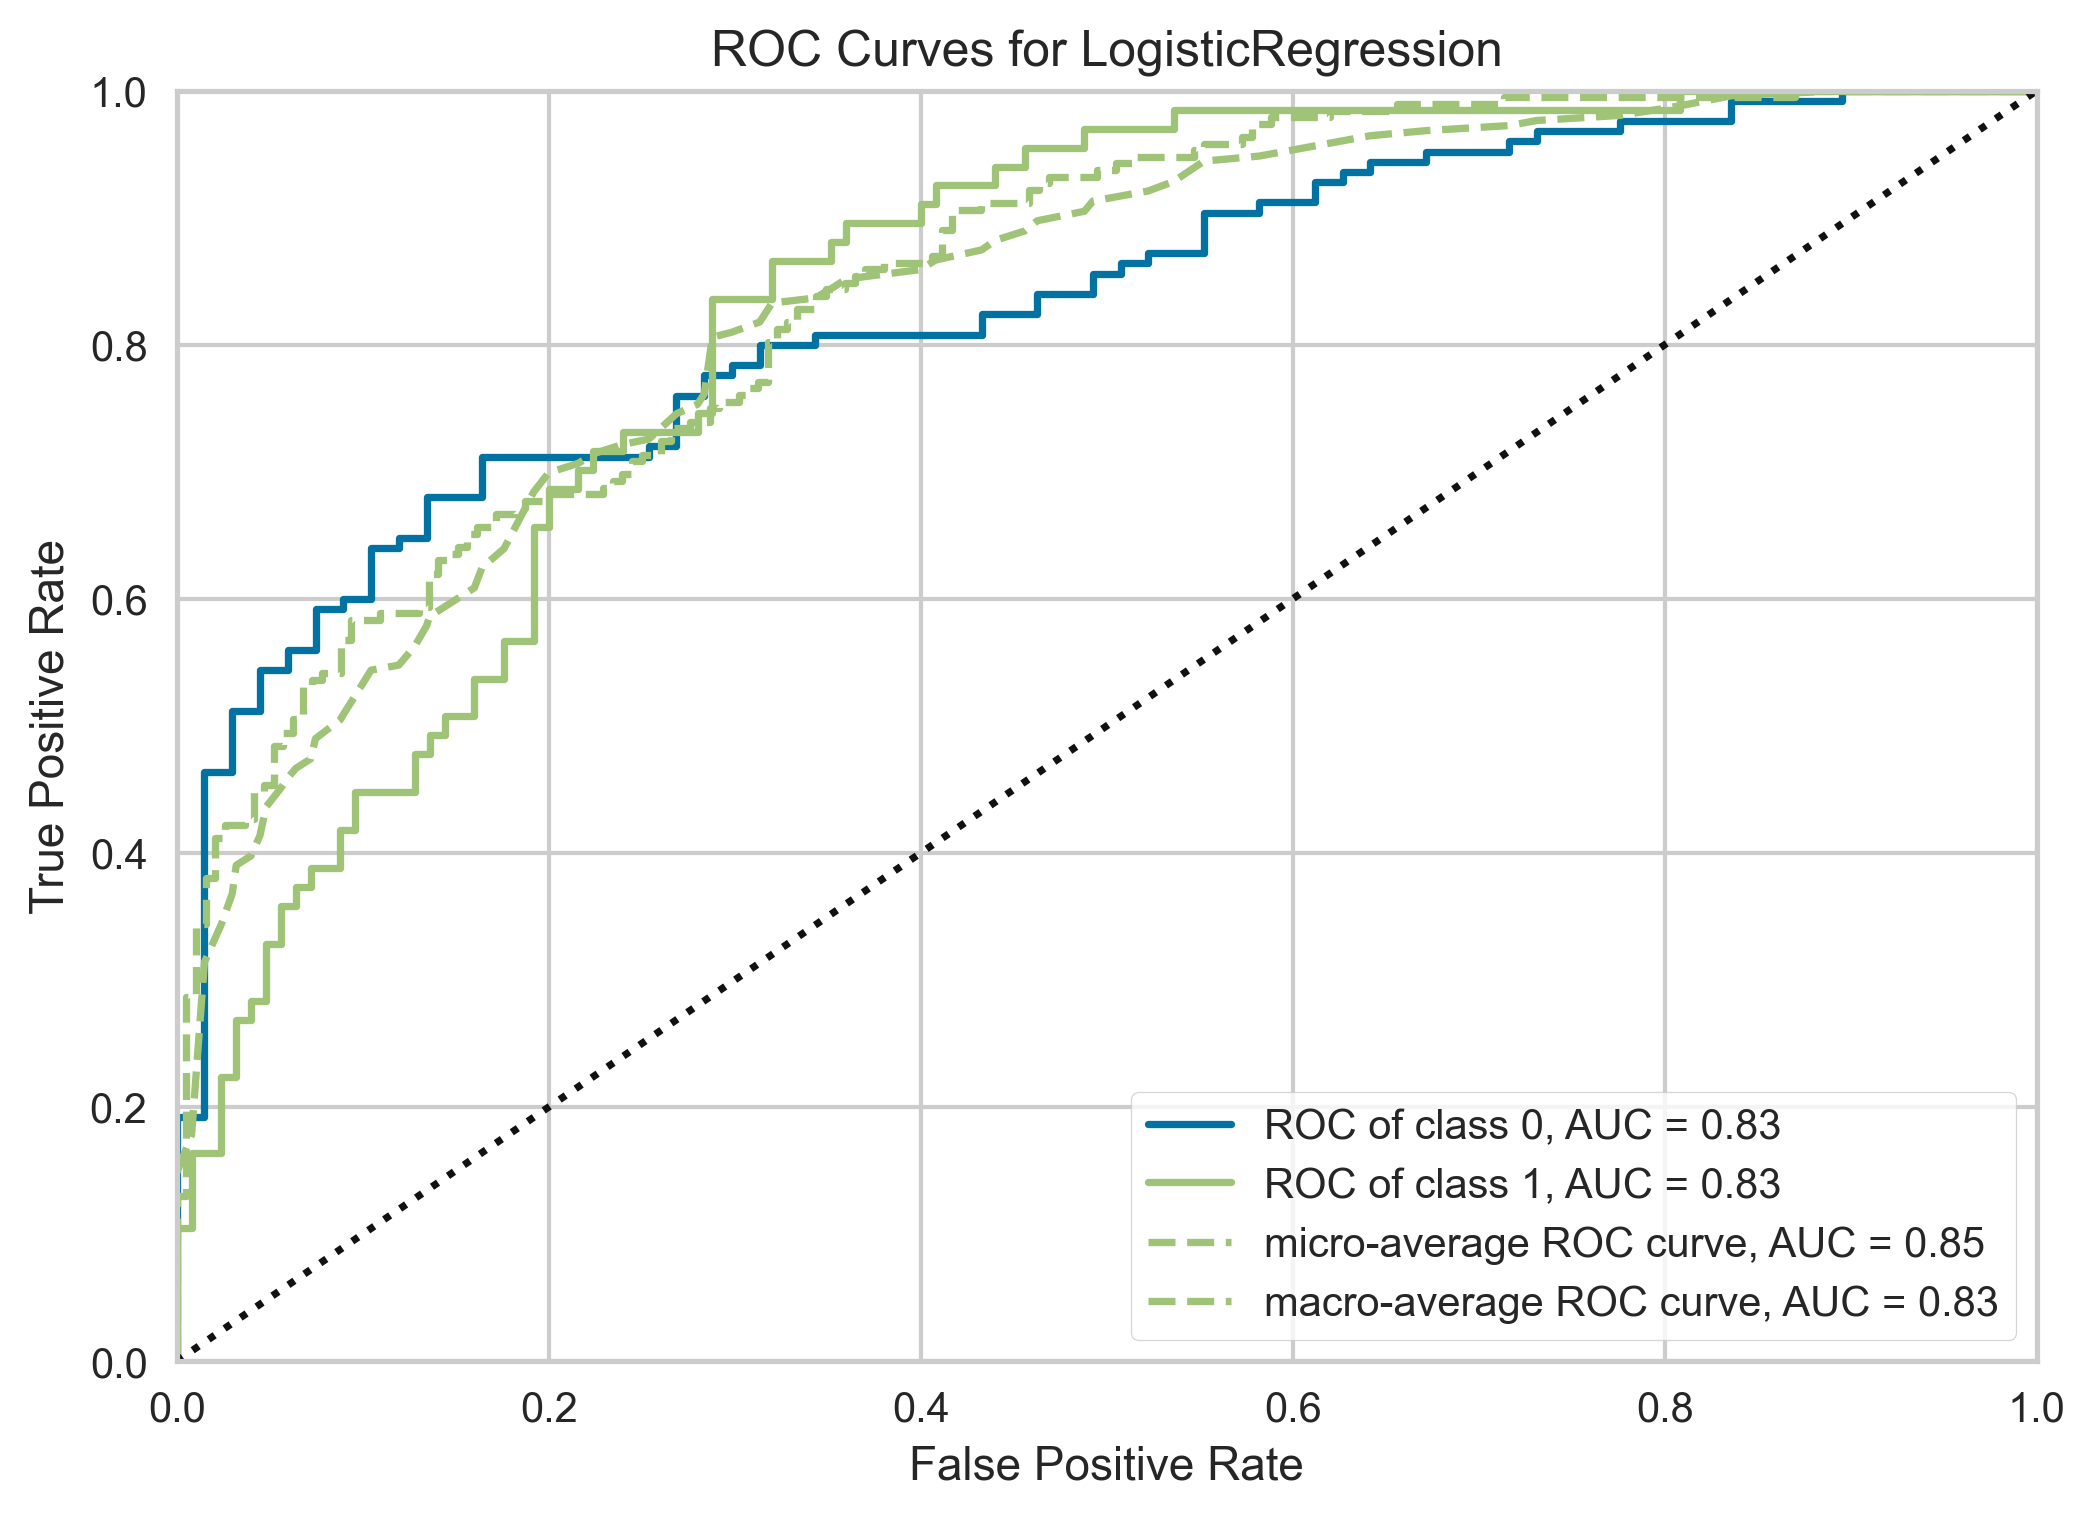

In [101]:
# ROC-kurve
import os
os.makedirs('figurer', exist_ok=True)
from IPython.display import Image, display

# Klassenavn for diabetes-datasettet
KLASSE_NAVN = {0: 'Ikke diabetes', 1: 'Diabetes'}

# Sett høyere DPI for matplotlib
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 300

# Lagre ROC-kurve (PyCaret lagrer til nåværende mappe, så vi flytter etterpå)
plot_model(tunet_modell, plot='auc', save=True)

# Flytt og gi nytt navn til filen
import shutil
if os.path.exists('AUC.png'):
    shutil.move('AUC.png', 'figurer/roc_kurve.png')
    print("Lagret: figurer/roc_kurve.png (300 DPI)")
    
# Vis det lagrede bildet
display(Image(filename='figurer/roc_kurve.png'))

**Figur 1: ROC-kurve (Receiver Operating Characteristic)**

| Klasse | Betydning |
|--------|-----------|
| 0 | Ikke diabetes |
| 1 | Diabetes |

---

### De fire ROC-kurvene forklart

PyCaret viser **fire** ROC-kurver – dette kan virke forvirrende, men hver har sin betydning:

| Kurve | Hva den måler | Hvordan tenke |
|-------|---------------|---------------|
| **ROC of class 0** | Evne til å identifisere *ikke-diabetes* | "Hvor godt skiller modellen ut de friske?" |
| **ROC of class 1** | Evne til å identifisere *diabetes* | "Hvor godt fanger modellen opp de syke?" |
| **Micro-average** | Vektet etter antall observasjoner | "Samlet ytelse, dominert av største klasse" |
| **Macro-average** | Uvektet gjennomsnitt av klassene | "Lik vekt til alle klasser" |

#### ROC for klasse 0 (Ikke diabetes)
- Behandler "Ikke diabetes" som den positive klassen
- TPR = Andel friske korrekt klassifisert som friske
- FPR = Andel syke feilaktig klassifisert som friske
- **Viktig for:** Å unngå å si at syke er friske (redusere falske negativer for diabetes)

#### ROC for klasse 1 (Diabetes) ← Vanligvis den viktigste!
- Behandler "Diabetes" som den positive klassen
- TPR = Andel med diabetes korrekt identifisert (Sensitivitet)
- FPR = Andel friske feilaktig klassifisert som diabetes
- **Viktig for:** Screening – fange opp alle med sykdom

#### Micro-average ROC
- Beregner TP, FP, TN, FN samlet for alle klasser
- Vekter etter antall observasjoner i hver klasse
- **Domineres av den største klassen** (i vårt tilfelle: ikke-diabetes)
- **Viktig for:** Samlet ytelse når alle prediksjoner teller likt

#### Macro-average ROC
- Beregner AUC for hver klasse separat, deretter tar gjennomsnittet
- **Gir lik vekt til alle klasser** uavhengig av størrelse
- Formel: Macro-AUC = (AUC_klasse0 + AUC_klasse1) / 2
- **Viktig for:** Når alle klasser er like viktige, uavhengig av frekvens

**Forskjellen illustrert:**

```
Datasett: 500 ikke-diabetes, 268 diabetes (ubalansert)

AUC (klasse 0) = 0.90  (500 observasjoner)
AUC (klasse 1) = 0.70  (268 observasjoner)

Micro-average ≈ 0.83  ← Vektet mot klasse 0 (større)
Macro-average = 0.80  ← Uvektet snitt: (0.90 + 0.70) / 2
```

**Hvilken skal du bruke?**

| Situasjon | Anbefalt metrikk | Begrunnelse |
|-----------|------------------|-------------|
| Balansert datasett | Micro ≈ Macro | Gir samme resultat |
| Ubalansert + alle klasser like viktige | **Macro** | Ikke dominert av stor klasse |
| Ubalansert + flest prediksjoner = viktigst | **Micro** | Reflekterer total nøyaktighet |
| Medisinsk diagnostikk | **AUC for sykdomsklassen** | Fokuser på det som betyr noe! |

---

### Hvordan "tenke" når du ser ROC-kurvene?

**Steg 1: Identifiser den klinisk viktigste klassen**
```
Spørsmål: Hva er konsekvensen av å MISSE denne tilstanden?

For diabetes-screening:
  - Misse en diabetes (FN) → Ubehandlet sykdom, komplikasjoner
  - Feilaktig tilordne diabetes til en frisk person (FP) → Unødvendig oppfølging

→ FN er verre → Fokuser på ROC for klasse 1 (diabetes)!
```

**Steg 2: Se på AUC for den viktigste klassen**
- AUC (klasse 1) > 0.8 → God evne til å fange pasienter med diabetes
- AUC (klasse 1) < 0.7 → Modellen misser mange syke

**Steg 3: Sammenlign de to klassekurvene**
- Hvis AUC(klasse 0) >> AUC(klasse 1) → Modellen er bedre på å identifisere friske enn syke
- Dette er ofte tilfellet ved ubalanserte datasett (flere friske enn syke)

**Steg 4: Micro-average for helhetsbilde**
- Gir ett tall å rapportere
- Men skjuler forskjeller mellom klassene!

---

### Eksempel på tolkning

```
AUC (klasse 0) = 0.85
AUC (klasse 1) = 0.78  
Micro-average  = 0.82

Tolkning:
- Modellen er BEDRE på å identifisere friske (0.85) enn syke (0.78)
- Micro-average (0.82) er høyere enn klasse 1 AUC
- For SCREENING ville vi foretrukket høyere AUC for klasse 1!
- Vurder: Juster terskel for å øke sensitivitet (Recall for klasse 1)
```

---

**Hvordan tolke AUC-verdier?**

| AUC | Tolkning | Klinisk brukbarhet |
|-----|----------|-------------------|
| 0.5 | Ikke bedre enn tilfeldig | ❌ Ubrukelig |
| 0.6-0.7 | Svak diskriminering | ⚠️ Begrenset |
| 0.7-0.8 | Akseptabel | ✅ Kan vurderes |
| 0.8-0.9 | God | ✅ Bra |
| >0.9 | Utmerket | ✅ Svært bra |

> 🏥 **Klinisk hovedregel:** For medisinsk diagnostikk, fokuser på **AUC for sykdomsklassen** (klasse 1). Micro-average kan være misvisende hvis datasettene er ubalanserte!


Lagret: figurer/forvirringsmatrise.png


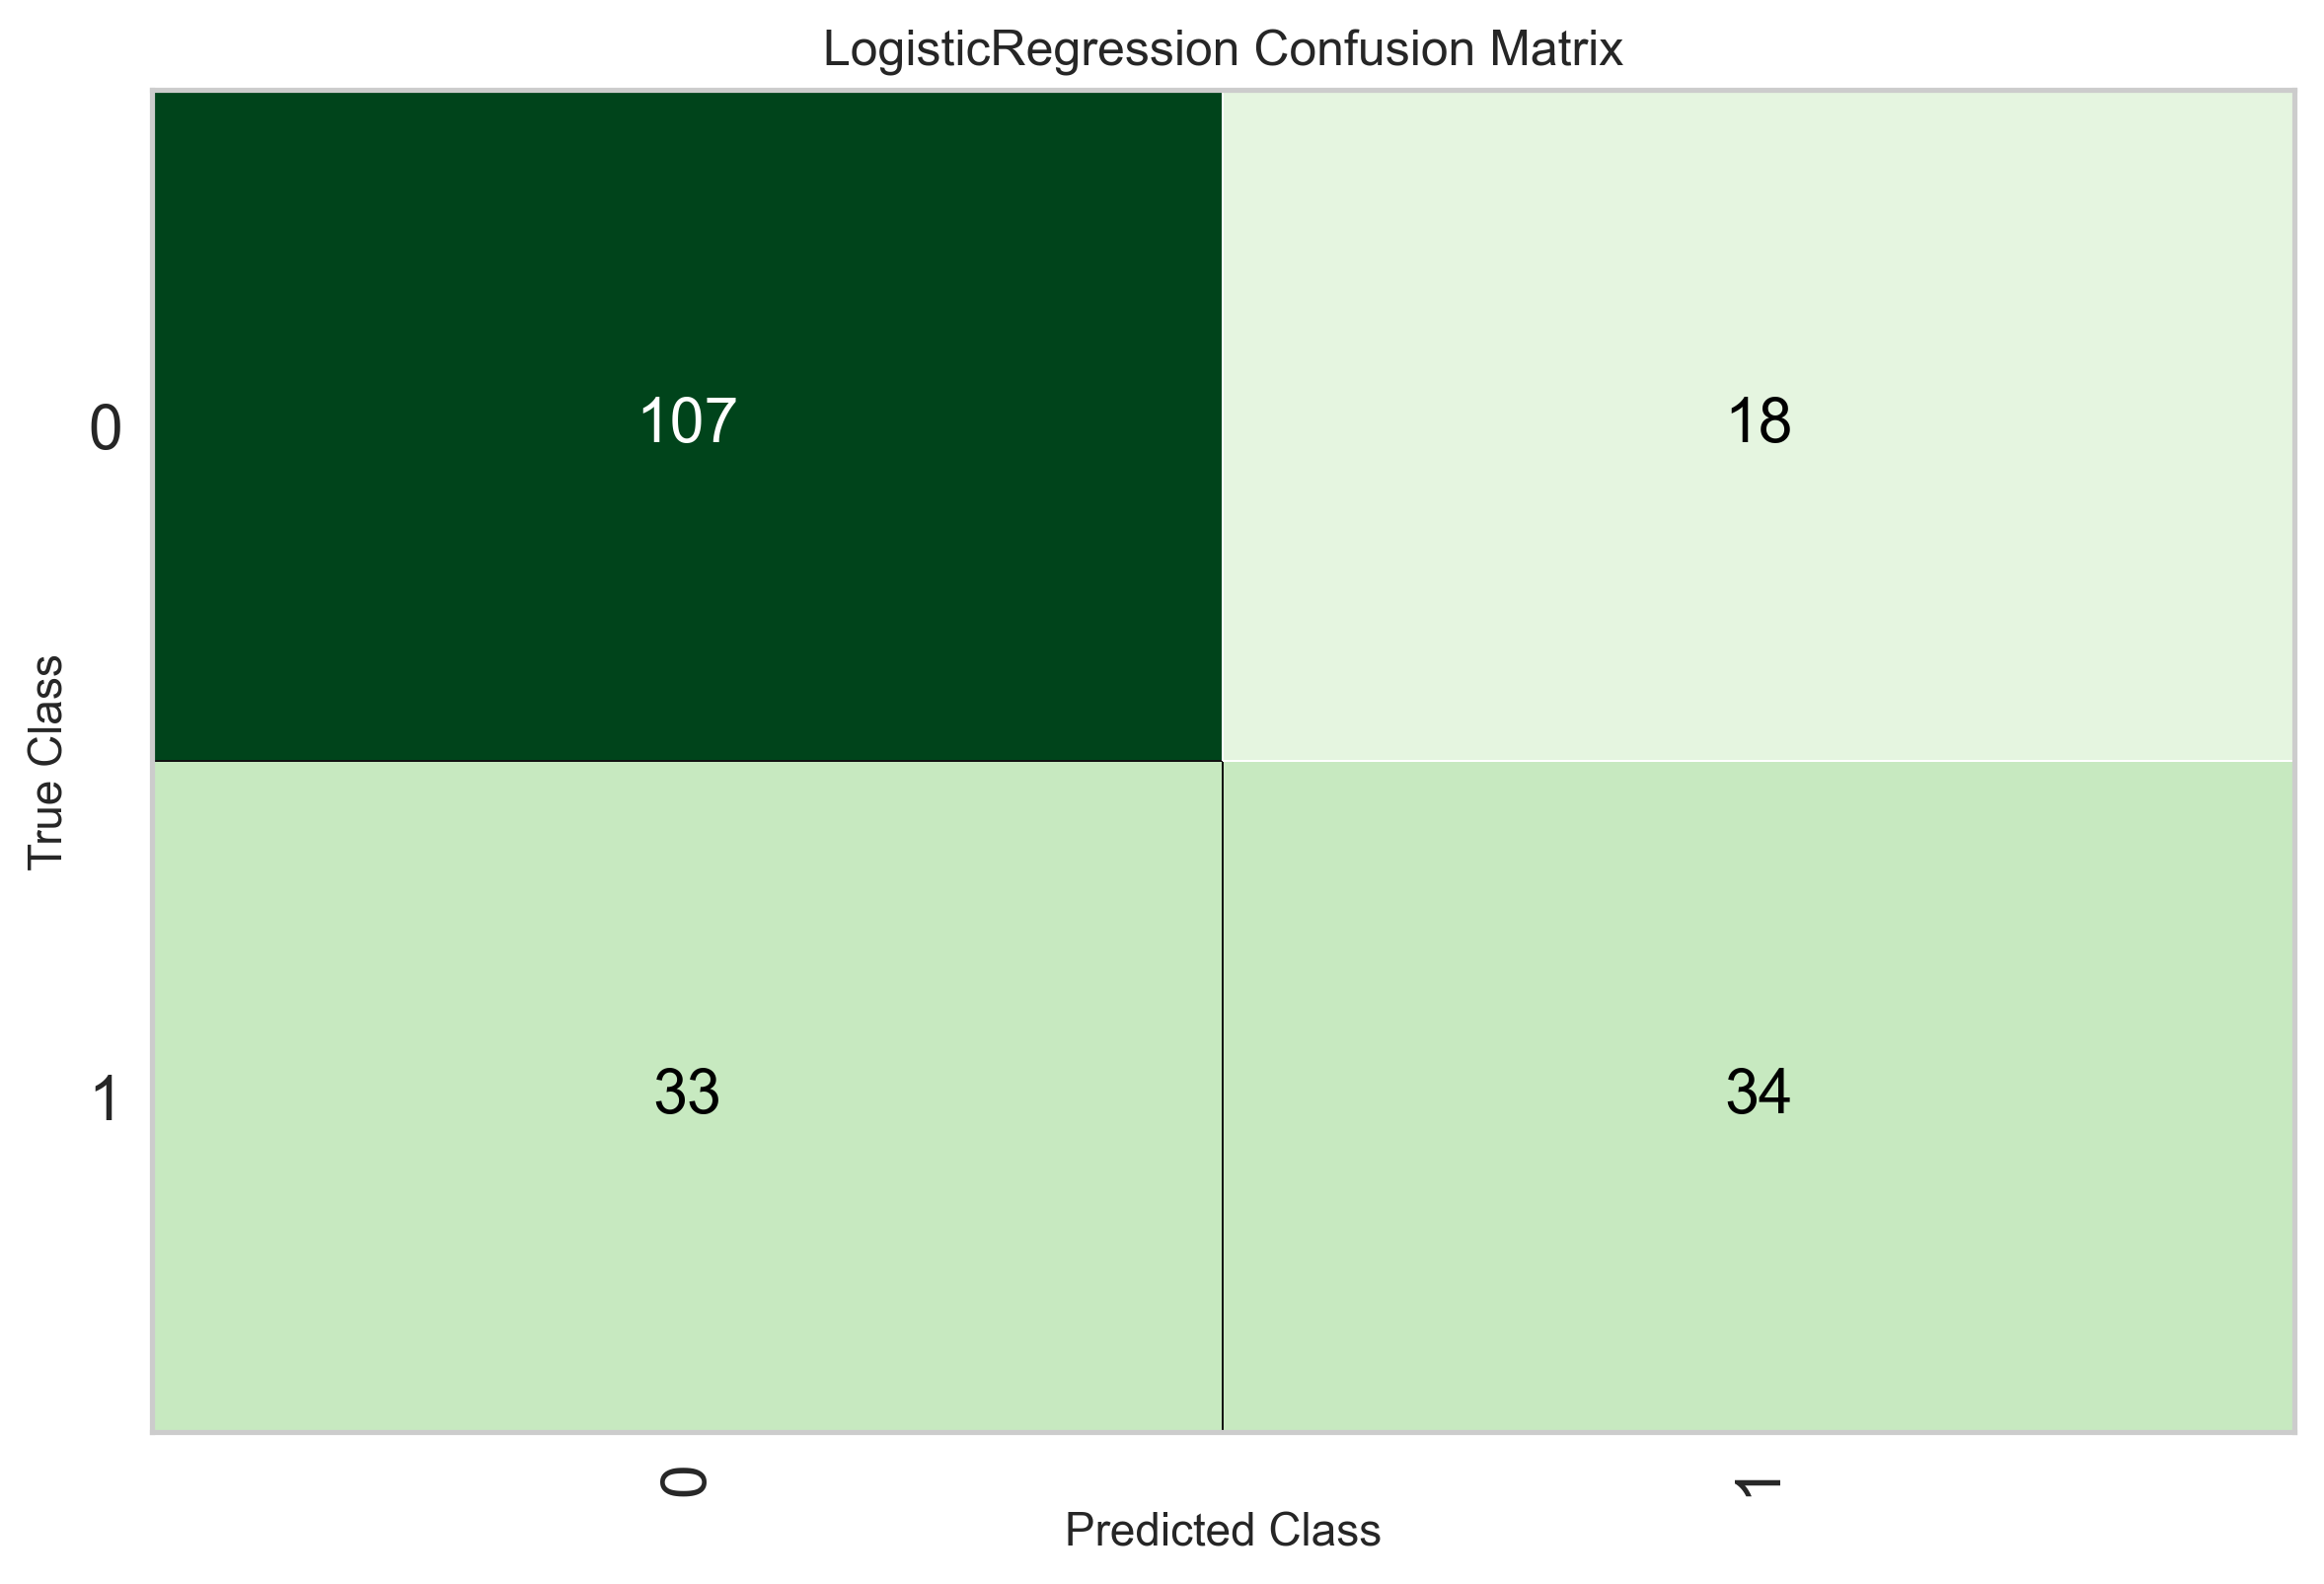

In [113]:
# Forvirringsmatrise
plot_model(tunet_modell, plot='confusion_matrix', save=True)

# Flytt og gi nytt navn
if os.path.exists('Confusion Matrix.png'):
    shutil.move('Confusion Matrix.png', 'figurer/forvirringsmatrise.png')
    print("Lagret: figurer/forvirringsmatrise.png")
    
display(Image(filename='figurer/forvirringsmatrise.png'))

**Figur 2: Forvirringsmatrise (Confusion Matrix)**

| | Predikert: 0 (Ikke diabetes) | Predikert: 1 (Diabetes) |
|---|---|---|
| **Faktisk: 0** | **TN** (True Negative) | **FP** (False Positive) |
| **Faktisk: 1** | **FN** (False Negative) | **TP** (True Positive) |

**Hva viser figuren?**
- **Diagonalen (TN og TP):** Korrekte prediksjoner ✅
- **Anti-diagonalen (FP og FN):** Feil prediksjoner ❌

**De fire cellene forklart:**

| Celle | Navn | Medisinsk betydning |
|-------|------|---------------------|
| **TN** | True Negative | Frisk person korrekt klassifisert som frisk |
| **TP** | True Positive | Syk person korrekt klassifisert som syk |
| **FP** | False Positive (Type I feil) | Frisk person feilaktig klassifisert som syk |
| **FN** | False Negative (Type II feil) | Syk person feilaktig klassifisert som frisk |

**Viktige metrikker fra matrisen:**
- **Sensitivitet (Recall)** = TP / (TP + FN) = Hvor mange syke fanger vi opp?
- **Spesifisitet** = TN / (TN + FP) = Hvor mange friske klassifiserer vi riktig?
- **PPV (Precision)** = TP / (TP + FP) = Av de vi sier er syke, hvor mange er faktisk syke?

> 🏥 **Klinisk vurdering:** I screening er FN (misset sykdom) ofte verre enn FP (falsk alarm). I bekreftende diagnostikk kan FP være kostbart (unødvendig behandling).


Lagret: figurer/klassifikasjonsrapport.png


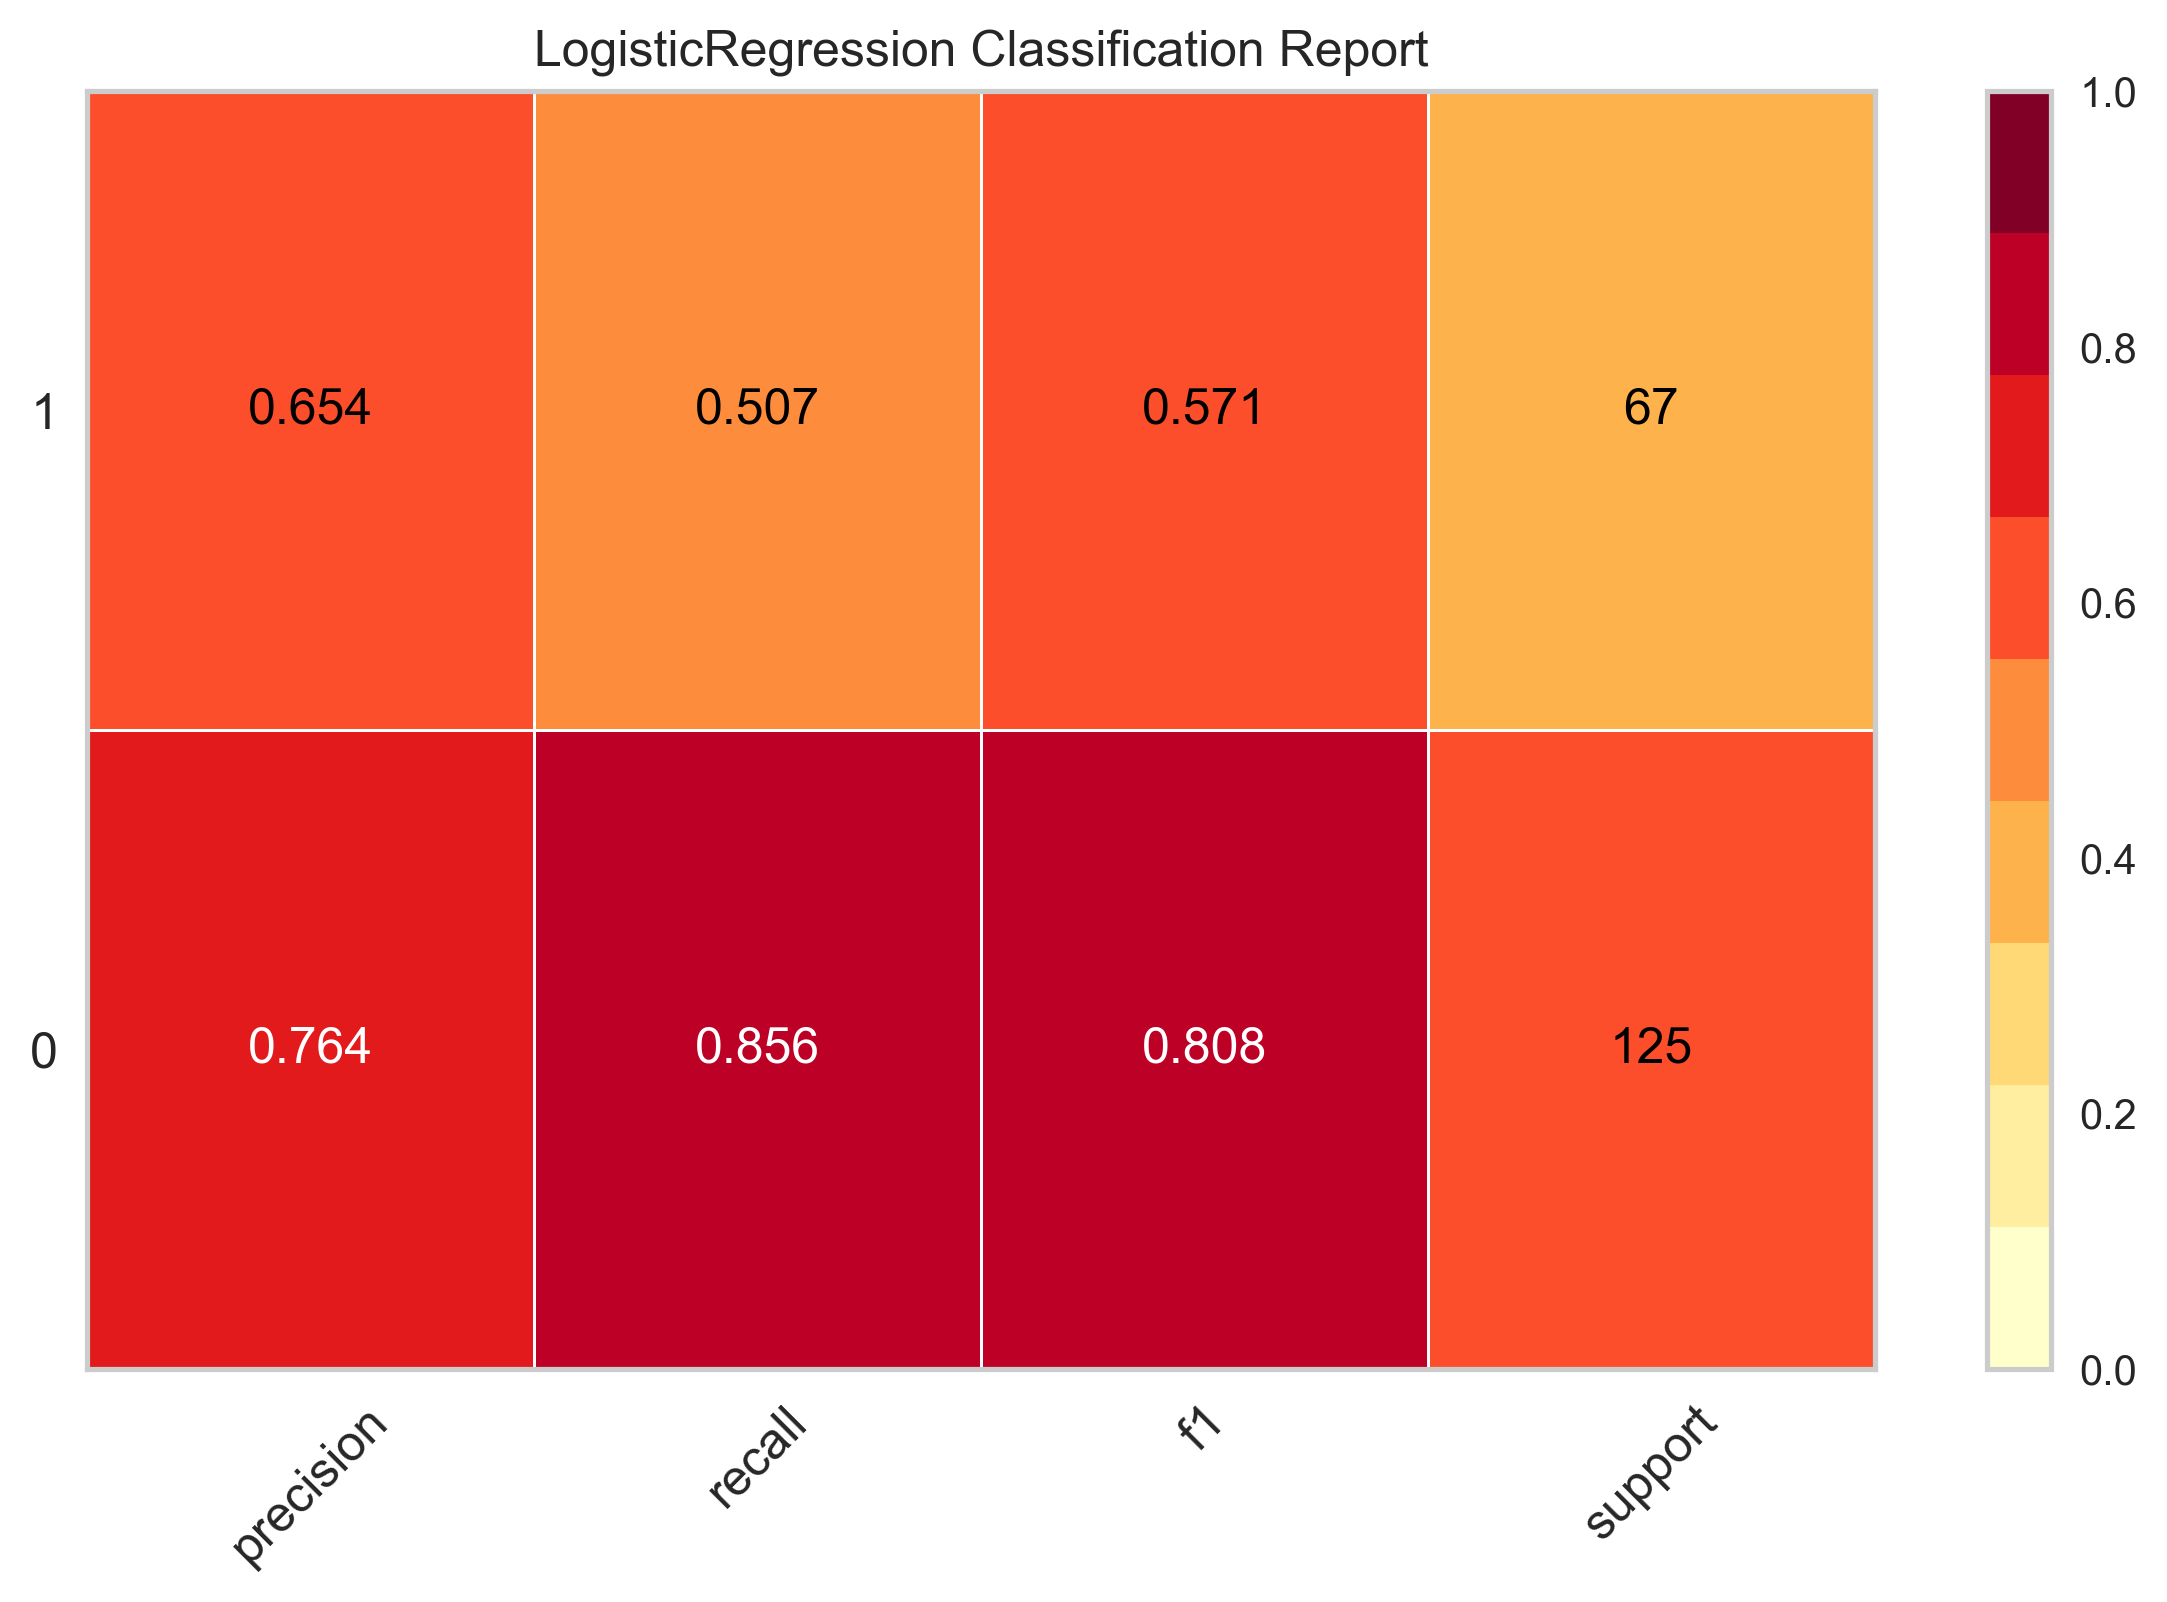

In [114]:
# Klassifikasjonsrapport (presisjon, recall, F1)
plot_model(tunet_modell, plot='class_report', save=True)

# Flytt og gi nytt navn
if os.path.exists('Class Report.png'):
    shutil.move('Class Report.png', 'figurer/klassifikasjonsrapport.png')
    print("Lagret: figurer/klassifikasjonsrapport.png")
    
display(Image(filename='figurer/klassifikasjonsrapport.png'))

**Figur 3: Klassifikasjonsrapport (Classification Report)**

| Klasse | Betydning |
|--------|-----------|
| 0 | Ikke diabetes |
| 1 | Diabetes |

**Hva viser figuren?**

Rapporten viser tre nøkkelmetrikker for **hver klasse**:

| Metrikk | Formel | Spørsmålet den besvarer |
|---------|--------|------------------------|
| **Precision** | TP / (TP + FP) | "Av de vi predikerer som denne klassen, hvor mange er riktig?" |
| **Recall** | TP / (TP + FN) | "Av alle som faktisk er denne klassen, hvor mange fant vi?" |
| **F1-score** | 2 × (Prec × Rec) / (Prec + Rec) | "Harmonisk gjennomsnitt av precision og recall" |

**Hvordan tolke fargene?**
- **Mørkere farge** = Høyere verdi = Bedre ytelse
- **Lysere farge** = Lavere verdi = Dårligere ytelse

**Support (antall observasjoner):**
- Viser hvor mange eksempler av hver klasse som finnes i testsettet
- Ubalanse her kan påvirke tolkningen

**Praktisk tolkning:**

| Scenario | Prioriter | Hvorfor |
|----------|-----------|---------|
| **Screening** | Høy Recall (klasse 1) | Ikke miss syke pasienter |
| **Bekreftende test** | Høy Precision (klasse 1) | Unngå falske alarmer |
| **Balansert** | Høy F1-score | Kompromiss mellom begge |

> 🏥 **Tips:** Hvis Recall for klasse 1 (Diabetes) er lav, betyr det at modellen misser mange diabetespasienter – alvorlig i en screening-kontekst!


Lagret: figurer/kalibrering.png


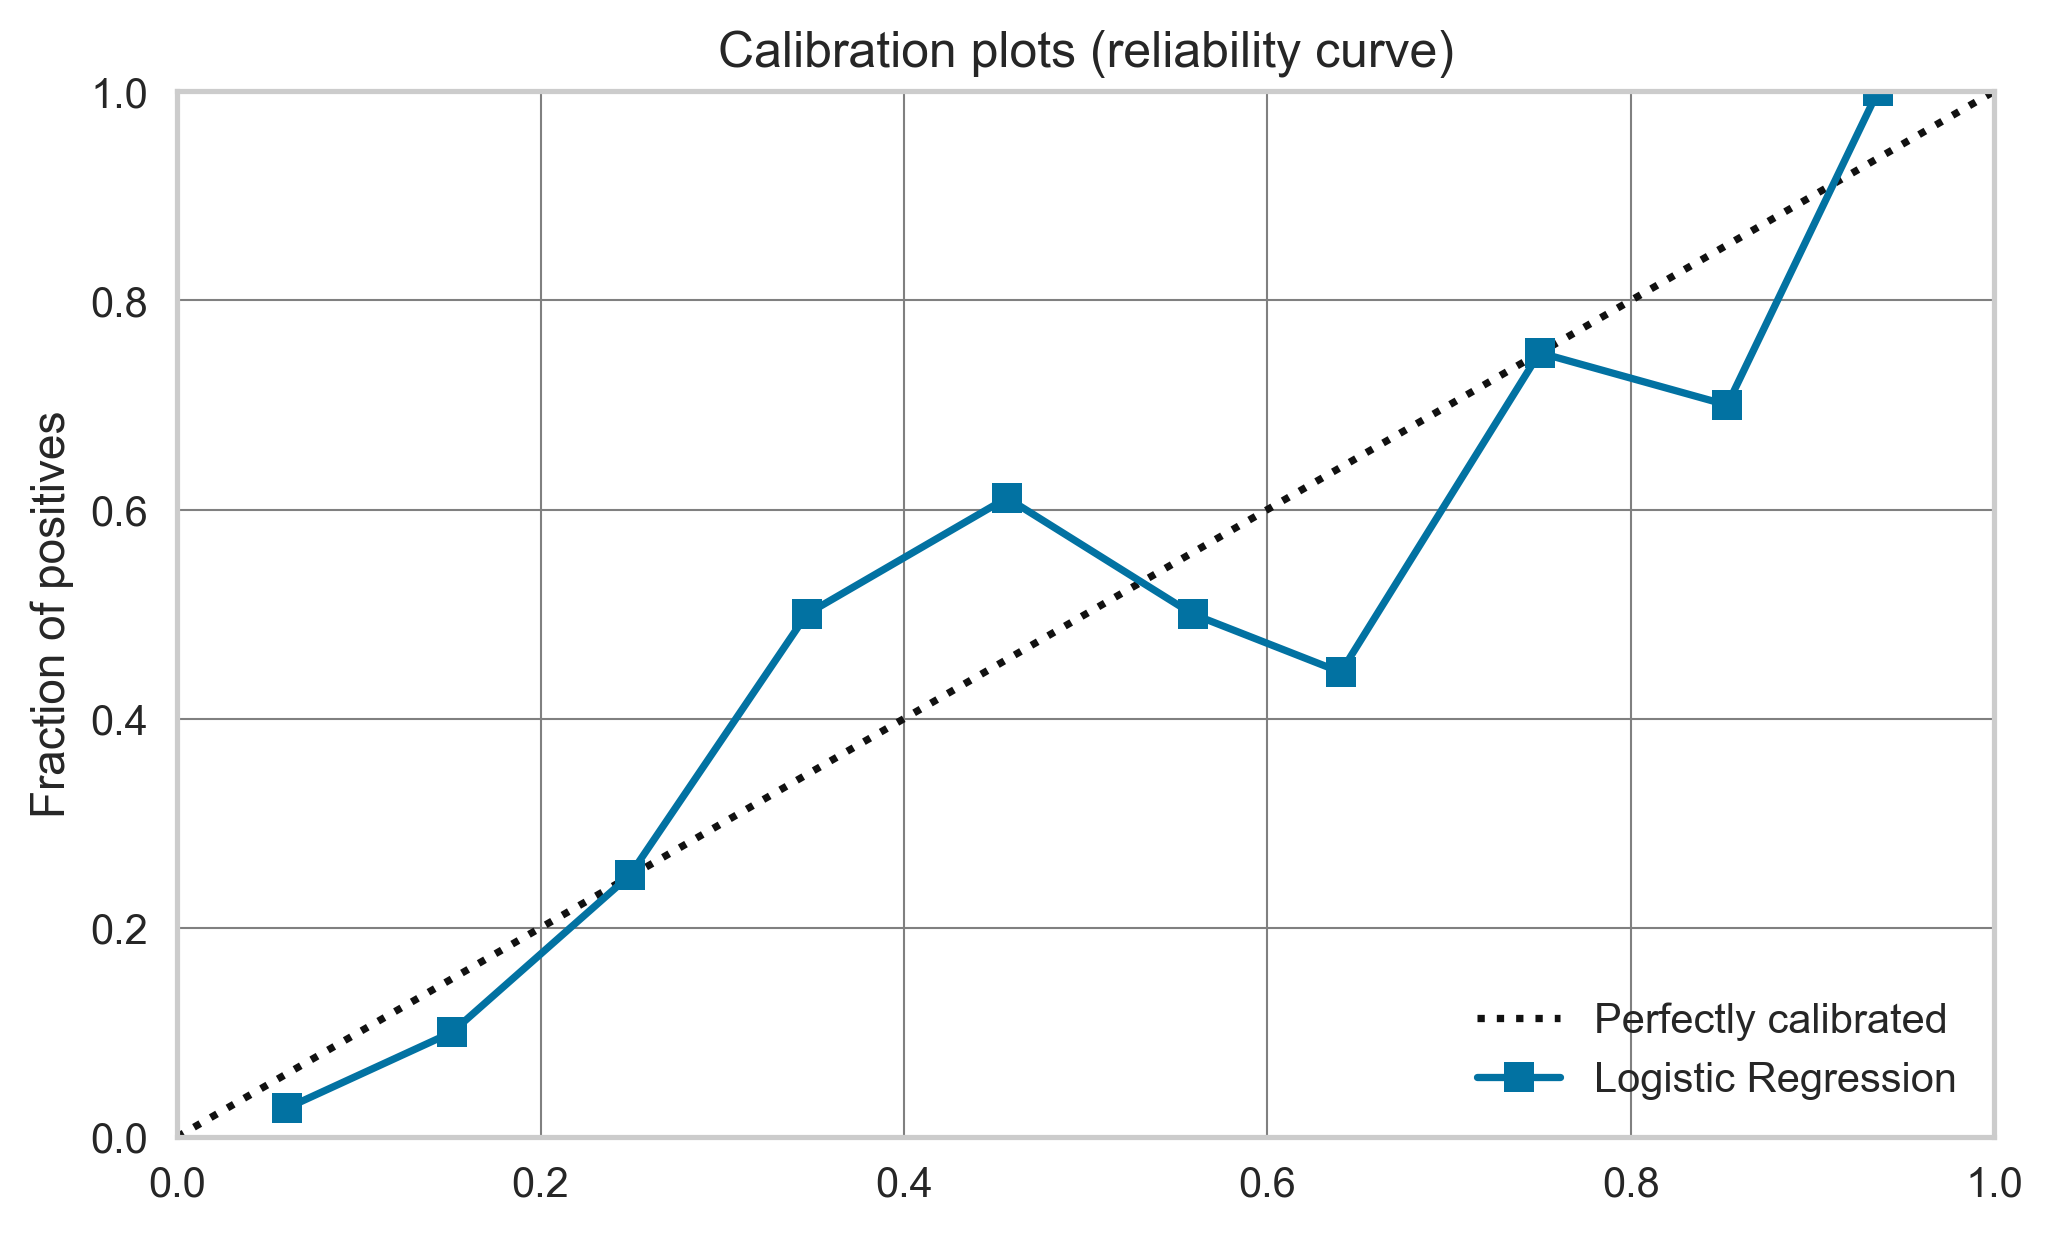

In [104]:
# Kalibreringsplot - VIKTIG for medisinsk bruk!
plot_model(tunet_modell, plot='calibration', save=True)

# Flytt og gi nytt navn
if os.path.exists('Calibration Curve.png'):
    shutil.move('Calibration Curve.png', 'figurer/kalibrering.png')
    print("Lagret: figurer/kalibrering.png")
    
display(Image(filename='figurer/kalibrering.png'))

**Figur 4: Kalibreringsplot (Calibration Curve) – VIKTIG for medisinsk bruk!**

**Hva er kalibrering?**

Kalibrering handler om hvorvidt modellens **predikerte sannsynligheter** samsvarer med **faktiske utfallsfrekvenser**.

**Eksempel:**
- Modellen sier "70% sjanse for diabetes" for 100 pasienter
- Hvis modellen er godt kalibrert, bør ca. 70 av disse faktisk ha diabetes
- Hvis bare 40 har diabetes, er modellen **dårlig kalibrert** (overestimerer risiko)

**Hvordan lese plottet?**

| Element | Betydning |
|---------|-----------|
| **Diagonal linje** | Perfekt kalibrering (ideal) |
| **Blå kurve** | Modellens faktiske kalibrering |
| **Over diagonalen** | Modellen *underestimerer* risiko |
| **Under diagonalen** | Modellen *overestimerer* risiko |

**Hvorfor er dette viktig i medisin?**

```
Scenario: Lege bruker modell til å informere pasient

Modell sier: "Du har 80% sjanse for diabetes"

Hvis modellen er GODT kalibrert:
  → Pasienten har faktisk ~80% sjanse
  → Informasjonen er pålitelig ✅

Hvis modellen er DÅRLIG kalibrert:
  → Kanskje bare 50% av "80%-pasienter" har diabetes
  → Pasienten får feil informasjon ❌
  → Kan føre til unødvendig angst eller feil beslutninger
```

**Kalibrering vs. diskriminering (AUC):**

| Egenskap | Måler | Eksempel |
|----------|-------|----------|
| **Diskriminering (AUC)** | Evne til å *rangere* pasienter | "Hvem er mest sannsynlig syk?" |
| **Kalibrering** | *Nøyaktighet* av sannsynligheter | "Er 70% virkelig 70%?" |

> 🏥 **Viktig:** En modell kan ha høy AUC men dårlig kalibrering! For klinisk beslutningstaking trenger du **begge deler**.


### Andre nyttige plott

| Plot | Kommando | Bruksområde |
|------|----------|-------------|
| Feature importance | `plot_model(m, 'feature')` | Hvilke variabler er viktigst |
| Precision-Recall | `plot_model(m, 'pr')` | Ubalanserte datasett |
| Learning curve | `plot_model(m, 'learning')` | Overfitting-deteksjon |
| Prediction error | `plot_model(m, 'error')` | Feilanalyse |

> 🏥 **Klinisk tips:** Kalibreringsplottet er spesielt viktig for medisinsk bruk. Det viser om modellens sannsynligheter er *pålitelige* – ikke bare om den diskriminerer godt.

---

## Steg 4b: Feature Importance – Hva driver prediksjonene? (XAI)

### Hvorfor er dette viktig i medisin?

I klinisk praksis er det ikke nok å vite *at* en modell predikerer diabetes – vi må forstå *hvorfor*.

| Spørsmål | Betydning |
|----------|-----------|
| "Hvilke variabler påvirker prediksjonene mest?" | Klinisk innsikt |
| "Er modellen fornuftig?" | Validering av domeneekspertise |
| "Bruker modellen rimelige sammenhenger?" | Oppdage bias/feil |
| "Kan jeg forklare dette til pasienten?" | Transparens og tillit |

> 🏥 **Klinisk motivasjon:** En modell som sier "høy glukose gir høy diabetesrisiko" er troverdig. En modell som sier "pasient-ID påvirker diabetesrisiko" er suspekt!

---

### Hva er Feature Importance?

Feature importance måler **hvor mye hver variabel bidrar til modellens prediksjoner**.

**I vår diabetes-kontekst:**

| Variabel | Forventet viktighet | Klinisk begrunnelse |
|----------|---------------------|---------------------|
| `glucose` | 🔴 Høy | Blodsukkernivå er direkte relatert til diabetes |
| `bmi` | 🔴 Høy | Overvekt er kjent risikofaktor |
| `age` | 🟡 Middels | Risiko øker med alder |
| `dpf` | 🟡 Middels | Diabetes Pedigree Function (arvelighet) |
| `pregnancies` | 🟢 Lav-middels | Svangerskapsdiabetes kan gi type 2 |
| `insulin` | 🟡 Middels | Insulinnivå indikerer metabolsk helse |
| `triceps` | 🟢 Lav | Hudfold (indirekte mål på kroppsfett) |
| `diastolic` | 🟢 Lav | Blodtrykk har svakere sammenheng |

---

### Ulike metoder for Feature Importance

PyCaret støtter flere metoder – hver med sine styrker:

| Metode | Beskrivelse | Fordeler | Ulemper |
|--------|-------------|----------|---------|
| **Model-basert** | Innebygd i modellen (f.eks. RF, GB) | Rask, enkel | Modellspesifikk |
| **Permutation** | Måler ytelsestap ved å blande verdier | Modell-agnostisk | Kan være ustabil |
| **SHAP** | Spillteoretisk forklaring | Teoretisk solid, lokal+global | Treg for store data |

---

### Datagrunnlag: Trening eller test?

**Viktig distinksjon:**

| Metode | Datagrunnlag | Forklaring |
|--------|--------------|------------|
| **Model-basert** (standard) | Lært fra **treningsdata** | "Hva lærte modellen var viktig under trening?" |
| **Permutation importance** | Beregnes på **testdata** | "Hvilke variabler påvirker ytelse på nye data?" |
| **SHAP** | Kan brukes på begge | Fleksibelt |

```
Model-basert importance:
  → Basert på strukturen modellen lærte (treningsdata)
  → Viser hva modellen "tror" er viktig

Permutation importance på testdata:
  → "Hvis vi ødelegger informasjonen i 'glucose', hvor mye faller AUC?"
  → Viser hva som faktisk påvirker ytelse på usett data
```

> 💡 **Anbefaling:** Bruk begge! Hvis de er enige = robust innsikt. Hvis de er uenige = grunn til å undersøke nærmere.


Lagret: figurer/feature_importance.png


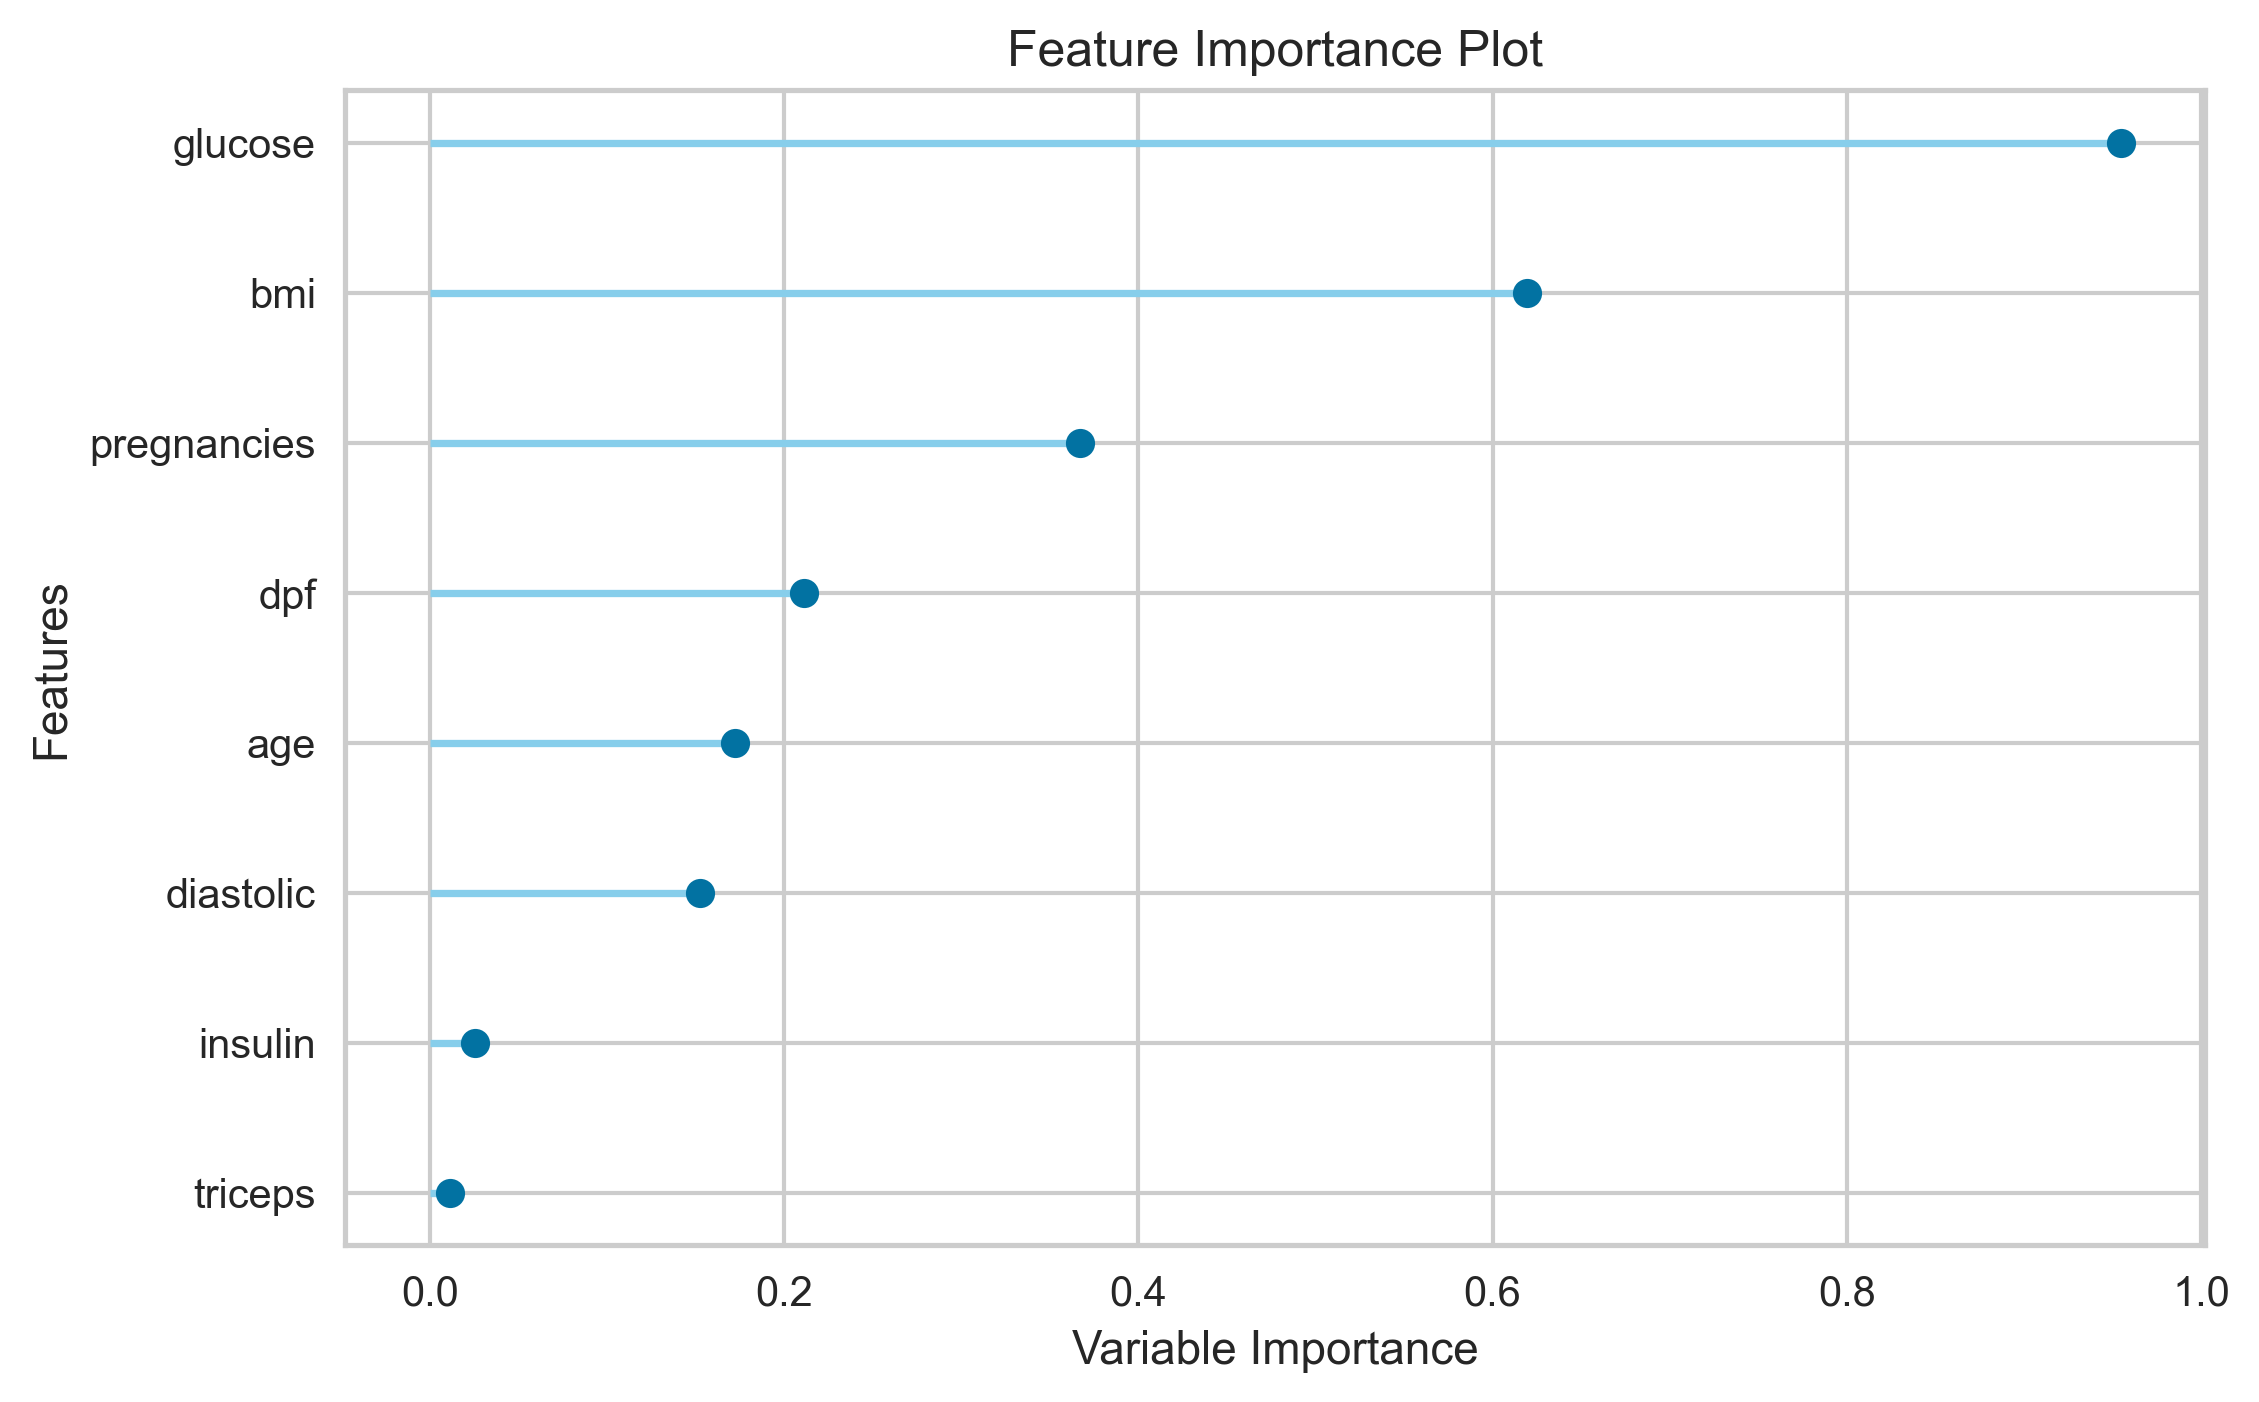

In [105]:
# Feature Importance (modellbasert)
# Viser hvilke variabler modellen vektlegger mest
plot_model(tunet_modell, plot='feature', save=True)

# Flytt og gi nytt navn
if os.path.exists('Feature Importance.png'):
    shutil.move('Feature Importance.png', 'figurer/feature_importance.png')
    print("Lagret: figurer/feature_importance.png")
    
display(Image(filename='figurer/feature_importance.png'))


**Figur 5: Feature Importance (Variabelviktighet)**

| Klasse | Betydning |
|--------|-----------|
| 0 | Ikke diabetes |
| 1 | Diabetes |

**Hva viser figuren?**

Feature importance viser **hvor mye hver variabel bidrar til modellens prediksjoner**, rangert fra viktigst (øverst) til minst viktig (nederst).

**Hvordan tolke dette?**

| Variabel høyt oppe | Tolkning |
|--------------------|----------|
| `glucose` | Blodsukkernivå er viktigst for prediksjon ✅ (forventet!) |
| `bmi` | Kroppsmasseindeks har stor påvirkning ✅ |
| `age` | Alder er relevant ✅ |

**Samsvarer dette med medisinsk kunnskap?**

```
Forventet (basert på klinisk viten):
  glucose > bmi > age > dpf > insulin > pregnancies > triceps > diastolic

Modellens ranking:
  [Se figuren – sammenlign med forventet!]

Hvis de avviker mye → Undersøk hvorfor!
```

**Viktige spørsmål å stille:**

1. **Er de viktigste variablene klinisk meningsfulle?**
   - Ja: Modellen har lært fornuftige sammenhenger ✅
   - Nei: Potensiell datalekkasje eller spuriøs korrelasjon ⚠️

2. **Er noen uventede variabler viktige?**
   - F.eks. hvis `diastolic` (blodtrykk) scorer høyest → Merkelig, undersøk!

3. **Er viktige variabler manglende?**
   - Hvis `glucose` scorer lavt → Noe er galt med data eller modell

---

### Datagrunnlag for denne figuren

> ⚠️ **Merk:** Denne figuren viser **modellbasert importance**, som er lært fra **treningsdata**. Den viser hva modellen "tror" er viktig basert på treningssettet.

For å se hva som faktisk påvirker ytelse på testdata, kan du bruke permutation importance (se under).


### Avansert: SHAP-verdier (SHapley Additive exPlanations)

SHAP gir en mer detaljert forklaring av feature importance:

| Aspekt | Standard importance | SHAP |
|--------|---------------------|------|
| **Granularitet** | Én verdi per variabel | Verdi per variabel *per observasjon* |
| **Retning** | Bare "viktig" | Viser om variabelen øker/senker prediksjon |
| **Teoretisk grunnlag** | Modellspesifikk | Spillteori (Shapley-verdier) |
| **Tolkbarhet** | "Glucose er viktig" | "Høy glucose øker diabetesrisiko med X%" |

---

### Kan SHAP brukes på logistisk regresjon?

**Ja, men med begrensninger:**

| Modelltype | SHAP-metode | PyCaret-støtte | Visualisering |
|------------|-------------|----------------|---------------|
| **Lineære modeller** (LR, Ridge) | LinearExplainer | ⚠️ Begrenset | Enklere |
| **Trebaserte modeller** (RF, XGB, LGBM) | TreeExplainer | ✅ Full | Rik (beeswarm, waterfall) |
| **Nevrale nettverk** | DeepExplainer/GradientExplainer | ⚠️ Varierer | Avhenger av arkitektur |

**Hvorfor fungerer SHAP bedre på trebaserte modeller?**

1. **TreeExplainer** er optimalisert og rask for beslutningstrær
2. **Interaksjonseffekter** fanges bedre av ikke-lineære modeller
3. **PyCaret** bruker TreeExplainer som standard – fungerer ikke på LR

> 💡 **Løsning:** Vi trener en trebasert modell (LightGBM eller Random Forest) for å demonstrere SHAP!


In [115]:
# For SHAP trenger vi en trebasert modell
# Tren en LightGBM-modell (rask og god SHAP-støtte)

print("Trener LightGBM-modell for SHAP-demonstrasjon...")
print("-" * 50)

# Opprett en LightGBM-modell
lgbm_modell = create_model('lightgbm', verbose=False)

print(f"LightGBM-modell opprettet: {type(lgbm_modell).__name__}")
print("-" * 50)


Trener LightGBM-modell for SHAP-demonstrasjon...
--------------------------------------------------
LightGBM-modell opprettet: LGBMClassifier
--------------------------------------------------


<details>
<summary>🔍 <strong>Se tilgjengelige plot-typer i PyCaret 3.x</strong> (klikk for å utvide)</summary>

```python
# Sjekk hvilke plot-typer som er tilgjengelige
available_plots = get_config('_available_plots')

print("Tilgjengelige plot-typer i PyCaret 3.x:")
for plot_name in sorted(available_plots.keys()):
    print(f"  '{plot_name}'")
```

**Output:**
```
Tilgjengelige plot-typer i PyCaret 3.x:
--------------------------------------------------
  'auc'
  'boundary'
  'calibration'
  'class_report'
  'confusion_matrix'
  'dimension'
  'error'
  'feature'
  'feature_all'
  'gain'
  'ks'
  'learning'
  'lift'
  'manifold'
  'parameter'
  'pipeline'
  'pr'
  'rfe'
  'threshold'
  'tree'
  'vc'
--------------------------------------------------
Totalt 21 plot-typer tilgjengelig
```

> ⚠️ **Merk:** SHAP-plots (`'summary'`, `'reason'`) er **ikke** i denne listen! For SHAP brukes `interpret_model()`, ikke `plot_model()`.

</details>

Genererer SHAP Summary Plot med interpret_model()...
--------------------------------------------------
Lagret: figurer/shap_summary.png


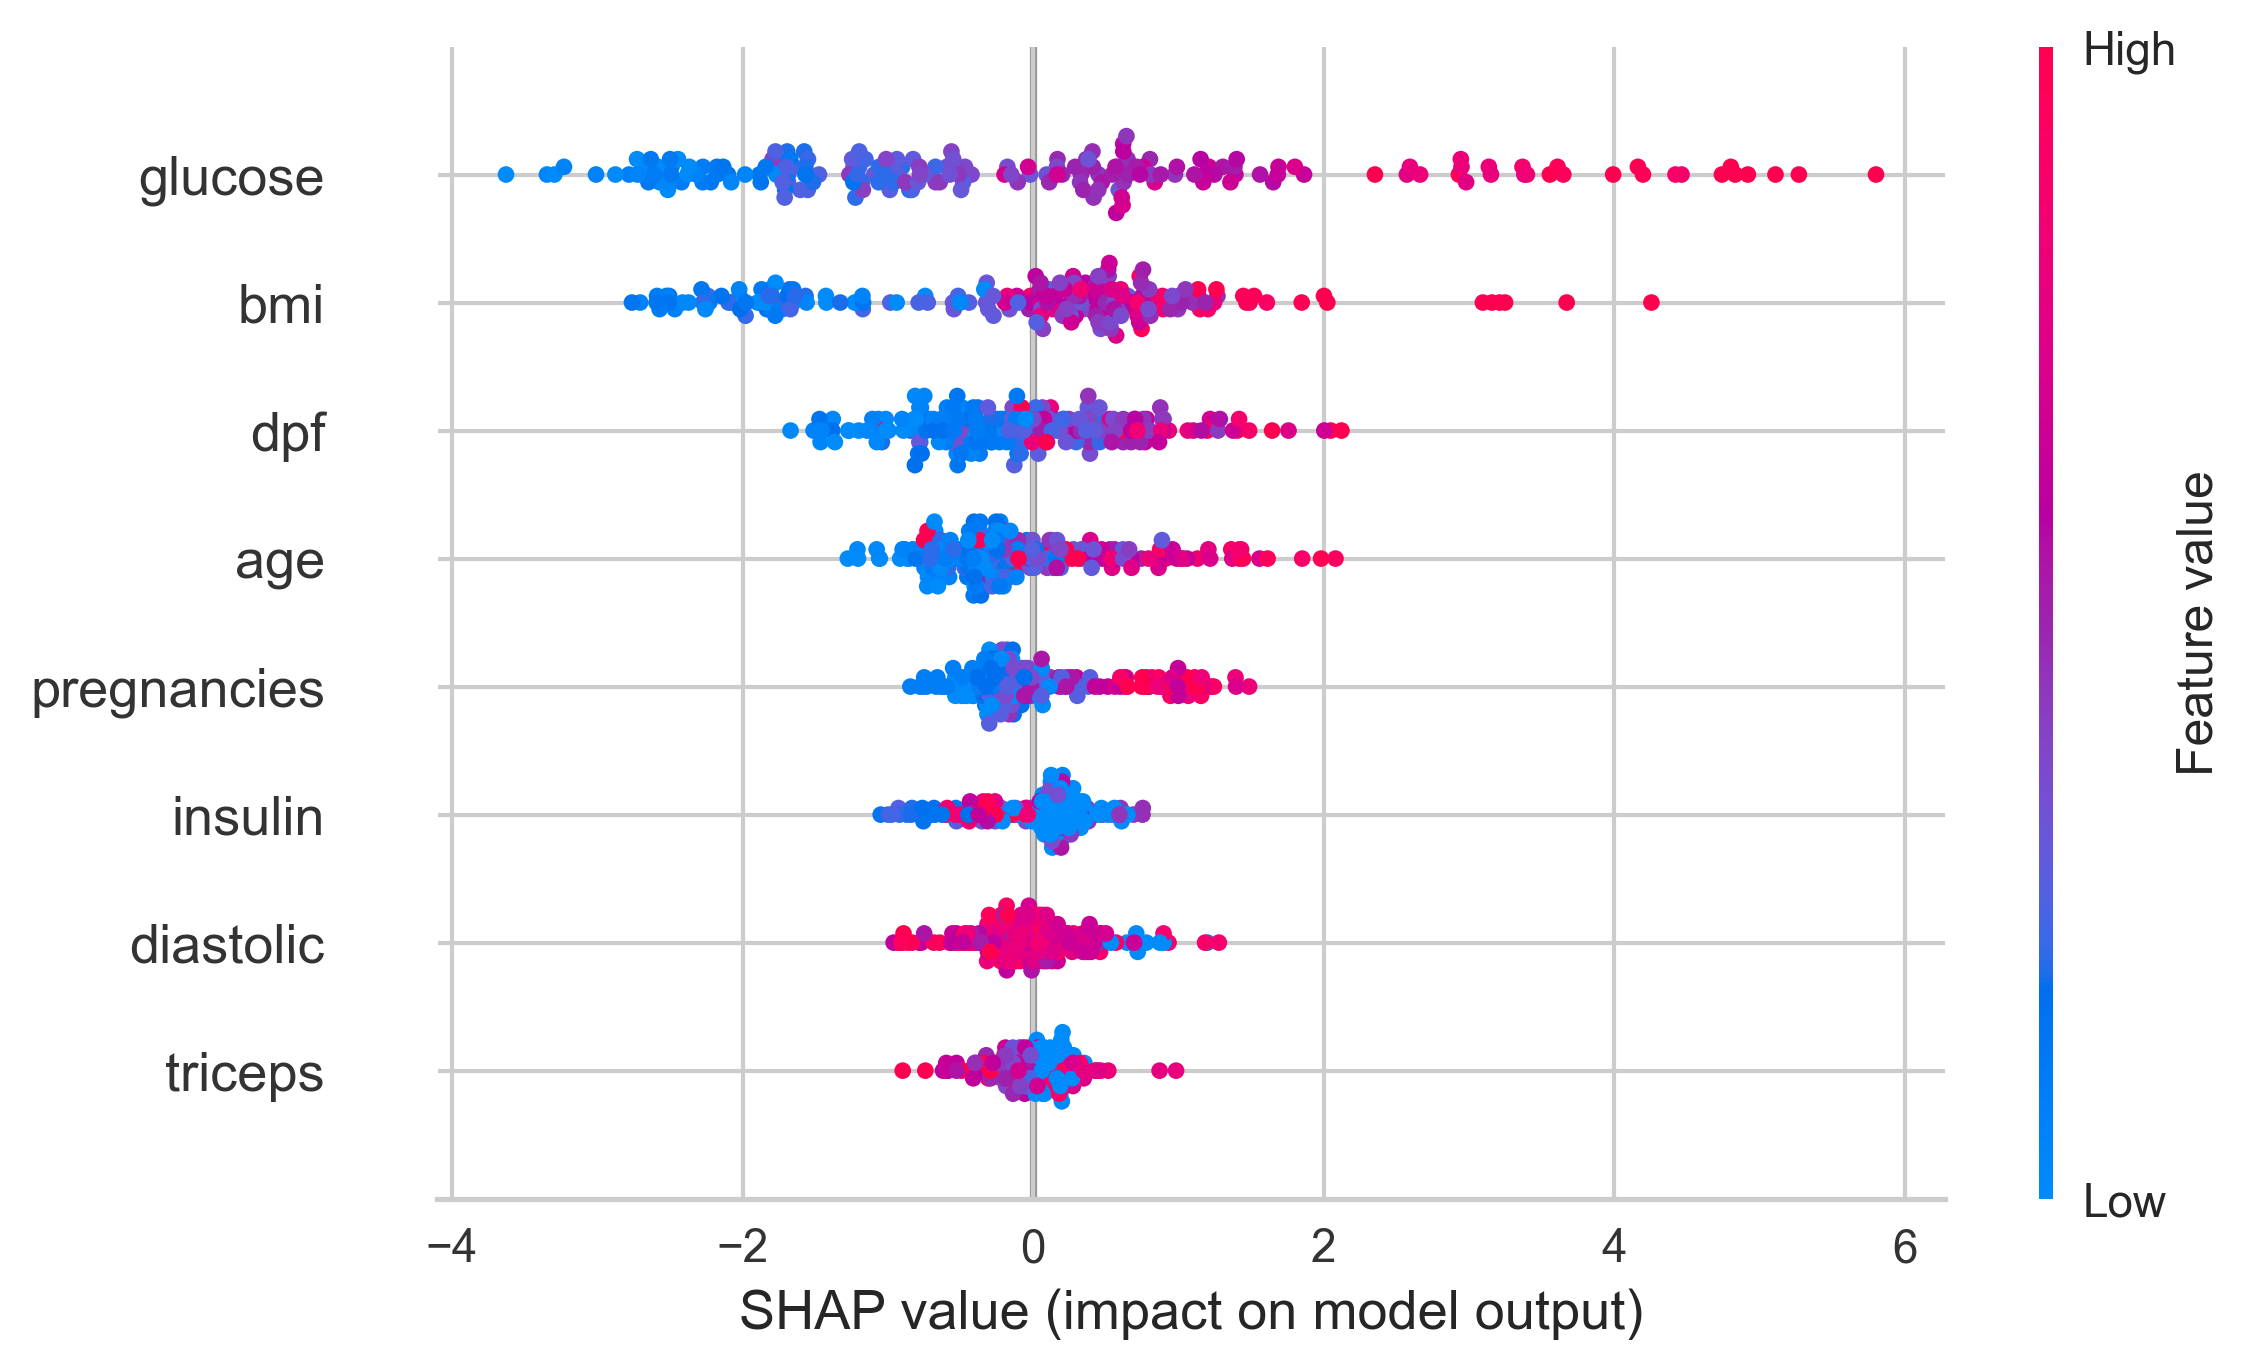

In [122]:
# I PyCaret 3.x brukes interpret_model() for SHAP - ikke plot_model()
from pycaret.classification import interpret_model

# SHAP Summary Plot (global forklaring)
print("Genererer SHAP Summary Plot med interpret_model()...")
print("-" * 50)

# interpret_model() viser plottet direkte
# Merk: save-parameteren forventer en MAPPE, ikke filnavn
# PyCaret legger til sitt eget filnavn (f.eks. "SHAP summary.png")
interpret_model(lgbm_modell, plot='summary', save='figurer')

# Flytt til ønsket filnavn
if os.path.exists('figurer/SHAP summary.png'):
    shutil.move('figurer/SHAP summary.png', 'figurer/shap_summary.png')
    print("Lagret: figurer/shap_summary.png")

# Vis figuren i notebooken
display(Image(filename='figurer/shap_summary.png'))


**Figur 6: SHAP Summary Plot (Beeswarm) – Global forklaring av LightGBM-modellen**

---

### Hva viser figuren?

SHAP Summary Plot (også kalt "beeswarm plot") viser **hvordan hver variabel påvirker modellens prediksjoner** på tvers av alle observasjoner i testsettet.

| Element | Beskrivelse |
|---------|-------------|
| **Y-akse** | Variabler rangert etter viktighet (viktigst øverst) |
| **X-akse** | SHAP-verdi: påvirkning på prediksjon (0 = ingen effekt) |
| **Hvert punkt** | Én observasjon (pasient) i testsettet |
| **Farge** | Variabelens verdi for den observasjonen (🔴 rød = høy, 🔵 blå = lav) |

---

### Detaljerte tolkningsregler for SHAP

#### X-aksen (SHAP-verdi)

| SHAP-verdi | Betydning |
|------------|-----------|
| **Positiv (+)** | Øker sannsynligheten for diabetes (klasse 1) |
| **Negativ (-)** | Senker sannsynligheten for diabetes (mot klasse 0) |
| **0** | Ingen effekt på prediksjon |
| **Stor absoluttverdi** | Stor påvirkning på prediksjonen |

#### Fargen (variabelens verdi)

| Farge | Betydning |
|-------|-----------|
| 🔴 **Rød** | Høy verdi av variabelen for denne observasjonen |
| 🔵 **Blå** | Lav verdi av variabelen for denne observasjonen |

---

### Hvordan tolke plottet?

**Eksempel: glucose (blodsukkernivå)**

```
                        SHAP-verdi
          ←─ Lavere risiko ─┼─ Høyere risiko ─→
                            │
glucose   🔵🔵🔵🔵🔵●●●●●●│●●●●●●🔴🔴🔴🔴🔴🔴
          Lav glucose       │       Høy glucose
          = lav risiko      │       = høy risiko
```

**Tolkning:**
- **Røde punkter (høy glucose) til høyre:** Høy glucose → positiv SHAP → øker diabetesrisiko ✅
- **Blå punkter (lav glucose) til venstre:** Lav glucose → negativ SHAP → senker diabetesrisiko ✅

Dette samsvarer med medisinsk kunnskap!

---

### Hva hvis mønsteret er "omvendt"?

For en variabel der **lav verdi øker risiko** (hypotetisk eksempel):

```
                        SHAP-verdi
          ←─ Lavere risiko ─┼─ Høyere risiko ─→
                            │
variabel  🔴🔴🔴🔴●●●●●●●│●●●●●●●🔵🔵🔵🔵🔵
          Høy verdi         │       Lav verdi
          = lav risiko      │       = høy risiko
```

---

### Oppsummert tolkningsregel

```
For hver observasjon (punkt):
  - Posisjon på X = Hvor mye denne variabelen påvirker DENNE pasientens prediksjon
  - Farge = Hva er verdien av variabelen for DENNE pasienten

Aggregert mønstergjenkjenning:
  - Røde punkter til høyre + blå til venstre? → Høy verdi øker risiko
  - Røde punkter til venstre + blå til høyre? → Lav verdi øker risiko
  - Blandet/spredt? → Kompleks eller svak sammenheng
```

> 🎯 **Hovedpoeng:** SHAP viser ikke bare *viktighet*, men også *retning* – noe vanlig feature importance ikke gjør!

---

### Klinisk tolkning av diabetes-modellen

| Variabel | Forventet sammenheng | SHAP-resultat | Vurdering |
|----------|---------------------|---------------|-----------|
| `glucose` | Høy → høyere risiko | ✅ Bekreftet | Fornuftig |
| `bmi` | Høy → høyere risiko | ✅ Bekreftet | Fornuftig |
| `age` | Høyere alder → høyere risiko | ✅ Bekreftet | Fornuftig |
| `dpf` | Høy arvelighet → høyere risiko | Se plottet | Sjekk |

---

### Hva forteller dette oss?

1. **Modellen har lært rimelige sammenhenger** – de viktigste variablene stemmer med medisinsk kunnskap
2. **Glucose er viktigst** – blodsukkernivå dominerer prediksjonene
3. **BMI og alder bidrar** – men mindre enn glucose
4. **Ingen åpenbare "red flags"** – ingen uventede variabler scorer høyt

> 🏥 **Klinisk validering:** Når SHAP-resultatene stemmer med etablert medisinsk kunnskap, gir det tillit til at modellen kan generalisere til nye pasienter.

---

### Viktige spørsmål å stille

✅ **Positive tegn:**
- Viktigste variabler er klinisk relevante
- Retning av påvirkning stemmer med medisin

⚠️ **Varselflagg (se etter disse):**
- Irrelevante variabler (f.eks. pasient-ID) scorer høyt → datalekkasje?
- Forventet viktige variabler scorer lavt → datakvalitetsproblemer?
- Retning er motsatt av forventet → modellen har lært feil?

---

### Sammenligning: SHAP på treningsdata

**Hvorfor sammenligne med treningsdata?**

Vi har nå sett SHAP-verdier for **testdata** (nye, usette pasienter). Men det kan være nyttig å også se på **treningsdata** for å:

| Formål | Spørsmål vi kan besvare |
|--------|-------------------------|
| **Konsistenssjekk** | Er mønstrene like mellom trening og test? |
| **Overfitting-deteksjon** | Ser modellen helt annerledes ut på treningsdata? |
| **Tydeligere mønstre** | Flere datapunkter kan gi klarere trender |
| **Debugging** | Hvis test-SHAP ser merkelig ut, hjelper dette forklare |

**Forventet resultat:**
- Hvis modellen generaliserer godt → **Like mønstre** på trening og test
- Hvis modellen overfitter → **Ulike mønstre** (treningsdata kan vise sterkere effekter)

> ⚠️ **Viktig:** For endelig evaluering og rapportering bør du alltid bruke **testdata**, da dette representerer modellens ytelse på fremtidige pasienter.


Genererer SHAP Summary Plot for TRENINGSDATA...
--------------------------------------------------
Lagret: figurer/shap_summary_train.png


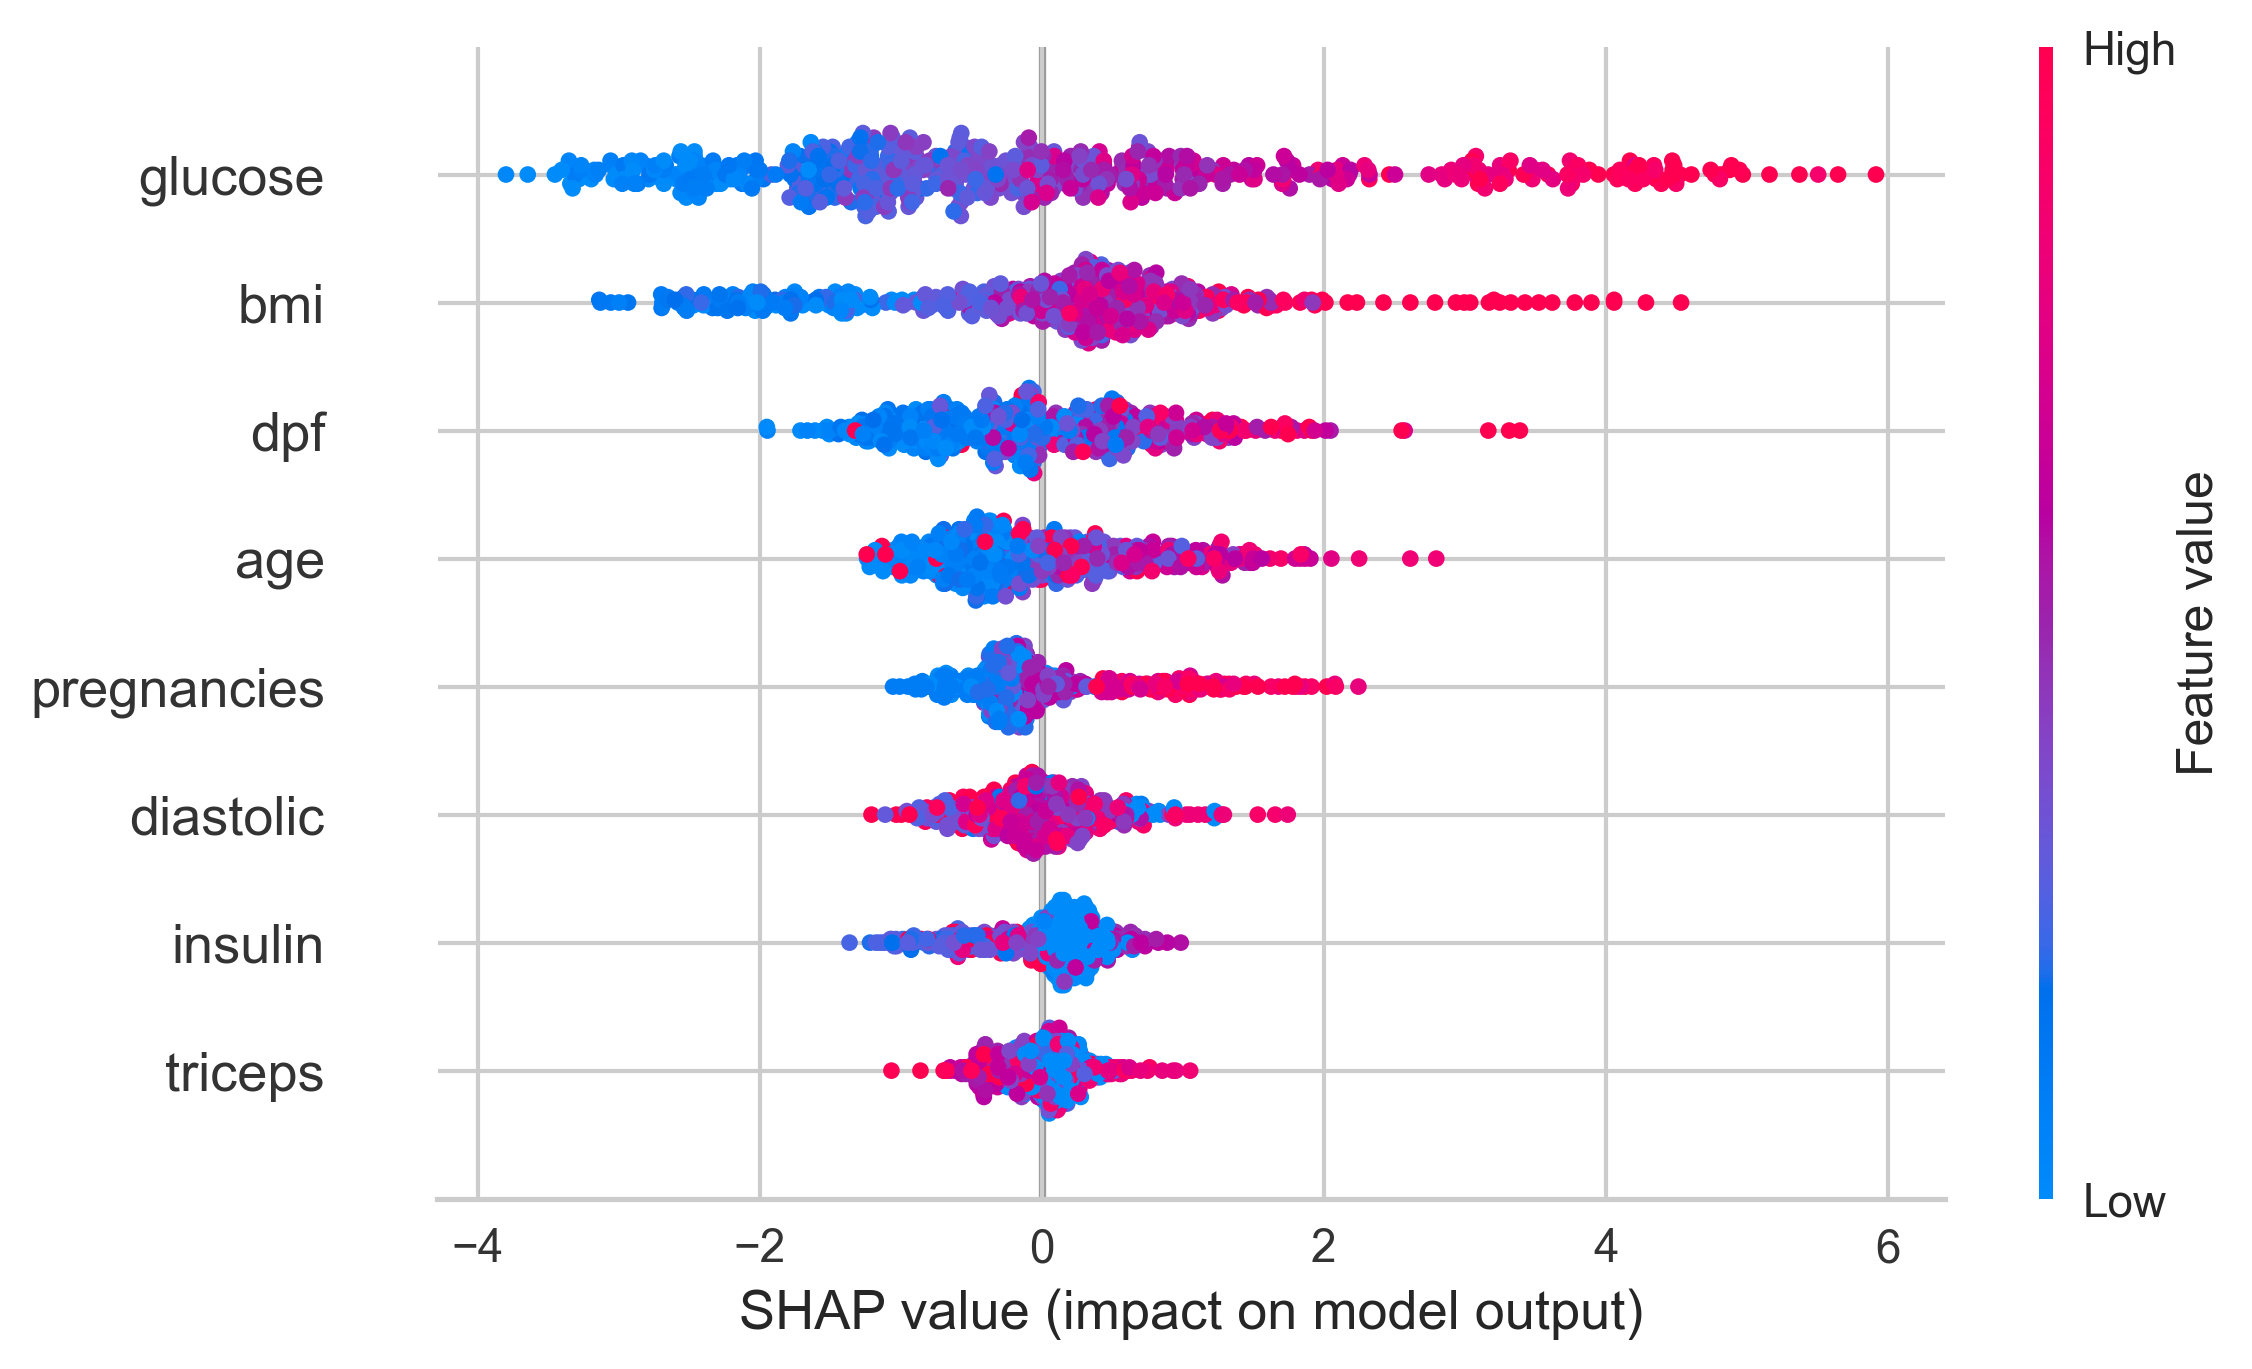

In [123]:
# SHAP Summary Plot for TRENINGSDATA
print("Genererer SHAP Summary Plot for TRENINGSDATA...")
print("-" * 50)

# Bruk use_train_data=True for å beregne SHAP på treningssettet
interpret_model(lgbm_modell, plot='summary', use_train_data=True, save='figurer')

# Flytt til ønsket filnavn
if os.path.exists('figurer/SHAP summary.png'):
    shutil.move('figurer/SHAP summary.png', 'figurer/shap_summary_train.png')
    print("Lagret: figurer/shap_summary_train.png")

# Vis figuren
display(Image(filename='figurer/shap_summary_train.png'))


**Figur 6b: SHAP Summary Plot – Treningsdata**

---

### Sammenligning: Testdata vs. Treningsdata

| Aspekt | Testdata (Figur 6) | Treningsdata (Figur 6b) |
|--------|--------------------|-----------------------|
| **Antall observasjoner** | ~154 (20%) | ~614 (80%) |
| **Representerer** | Fremtidige pasienter | Pasienter modellen lærte fra |
| **Punkter i plottet** | Færre, mer spredt | Flere, tydeligere mønstre |

---

### Hva skal du se etter?

**✅ Tegn på god generalisering:**
- Samme variabler er viktigst i begge plott
- Samme retning på effektene (røde/blå punkter på samme side)
- Lignende spredning av SHAP-verdier

**⚠️ Tegn på potensiell overtilpasning:**
- Helt forskjellig ranking av variabler
- Mye sterkere effekter i treningsdata enn testdata
- Variabler som "forsvinner" eller "dukker opp" mellom datasettene

---

### Tolkning for diabetes-modellen

Sammenlign de to figurene:

| Variabel | Testdata | Treningsdata | Konsistent? |
|----------|----------|--------------|-------------|
| `glucose` | Viktigst? | Viktigst? | ✅/❌ |
| `bmi` | Rangering? | Rangering? | ✅/❌ |
| `age` | Rangering? | Rangering? | ✅/❌ |
| Retning | Rød→høyre? | Rød→høyre? | ✅/❌ |

> 💡 **Fyll inn tabellen basert på dine resultater!**

---

### Konklusjon

```
Hvis mønstrene er LIKE:
  → Modellen har lært stabile, generaliserbare sammenhenger ✅
  → Høy tillit til at modellen vil fungere på nye pasienter

Hvis mønstrene er ULIKE:
  → Modellen kan være overtilpasset til treningsdata ⚠️
  → Vurder: mer regularisering, enklere modell, mer data
```

> 🏥 **Klinisk implikasjon:** En modell som viser konsistente SHAP-mønstre mellom trening og test er mer pålitelig for klinisk bruk.


### SHAP Reason Plot – Forklare én enkelt prediksjon

SHAP kan også forklare **hvorfor modellen ga en bestemt prediksjon for én pasient**. Dette er ekstremt nyttig for klinisk kommunikasjon.

**Eksempel-scenario:**
> "Pasient #5 fikk lav diabetesrisiko. Hvilke faktorer bidro til dette?"

eller motsatt:

> "Pasient X fikk høy diabetesrisiko. Hvorfor?"

SHAP Reason Plot (waterfall) viser hvilke variabler som **dyttet prediksjon opp** (mot diabetes) og hvilke som **dyttet ned** (mot ikke-diabetes).

Genererer SHAP Reason Plot...
--------------------------------------------------
Posisjon i testsettet: 5
Opprinnelig indeks i datasettet: 653
Antall observasjoner i testsettet: 192
--------------------------------------------------
Pasient #5 variabler:
     pregnancies  glucose  diastolic  triceps  insulin        bmi    dpf   age
653          2.0    120.0       54.0      0.0      0.0  26.799999  0.455  27.0
--------------------------------------------------
Faktisk utfall: Ikke diabetes (klasse 0)
--------------------------------------------------
Lagret: figurer/shap_reason.png (300 DPI)


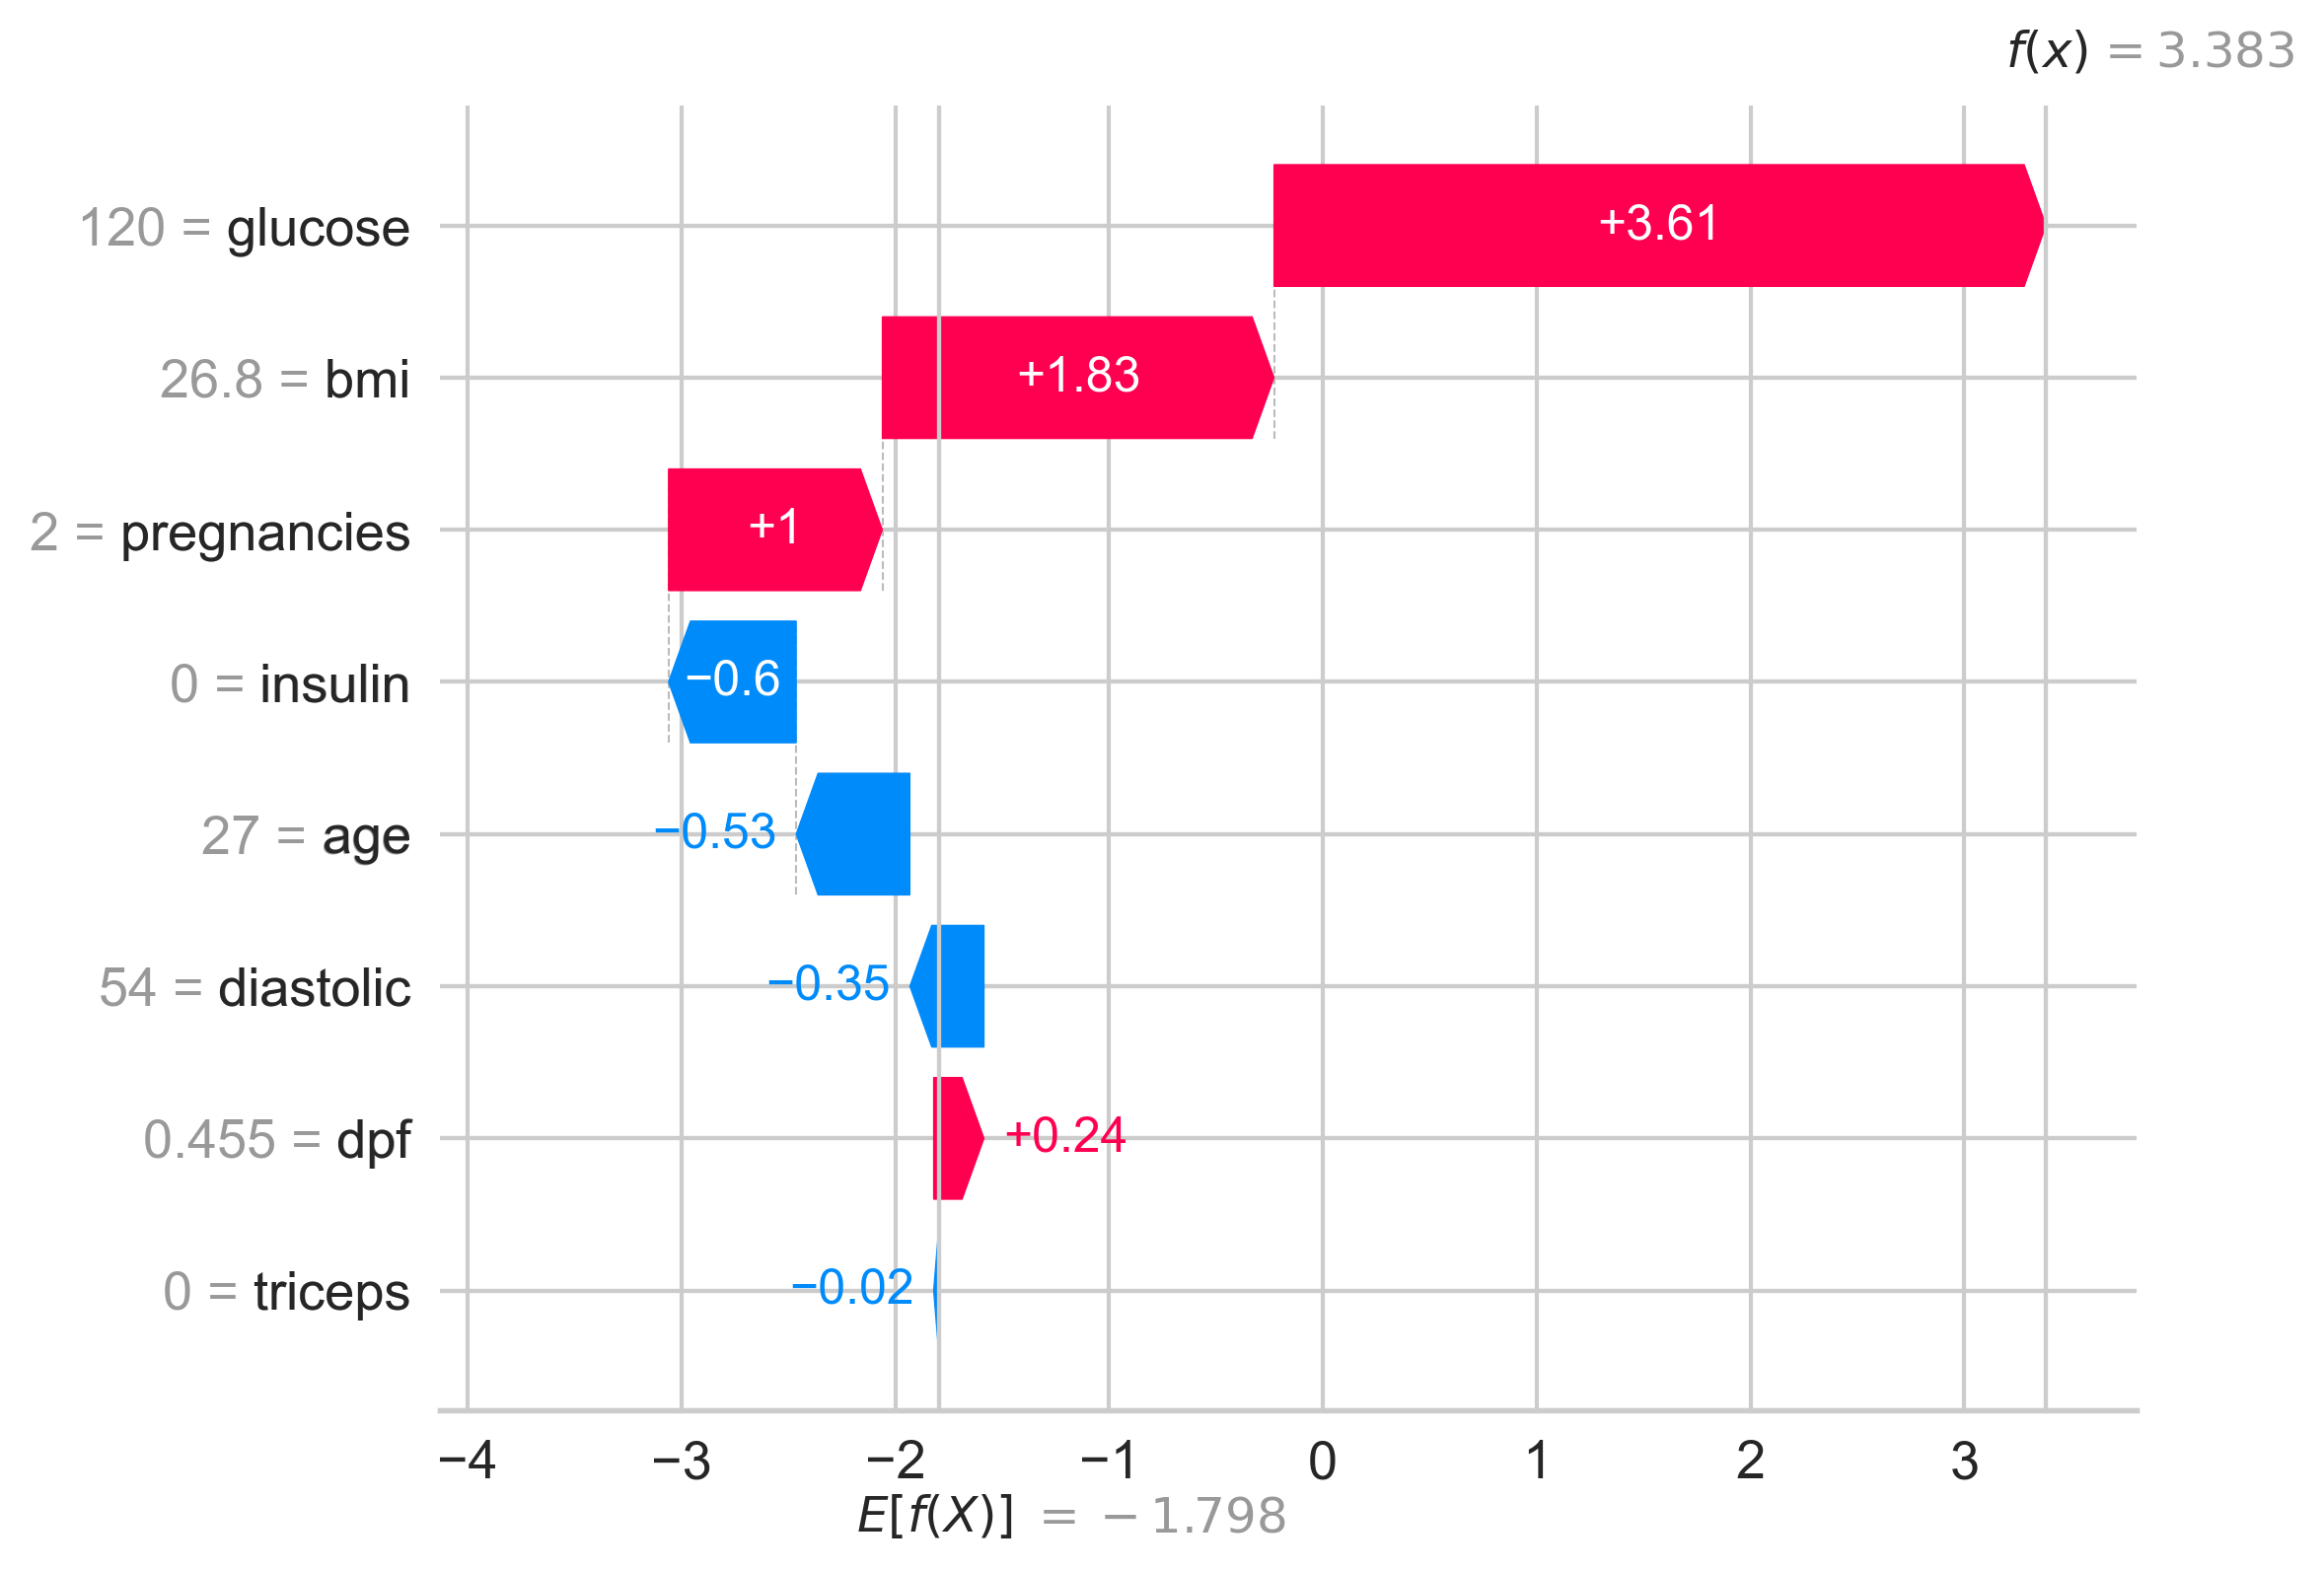

In [129]:
# SHAP Reason Plot for én enkelt observasjon (lokal forklaring)
# Vi velger observasjon #5 fra testsettet som eksempel

obs_nr = 5  # Endre dette for å se andre pasienter (0 til len(X_test)-1)

print("Genererer SHAP Reason Plot...")
print("-" * 50)

# Hent testdata for å vise pasientens verdier
X_test_data = get_config('X_test')
y_test_data = get_config('y_test')

# Eksplisitt informasjon om hvilken pasient vi ser på
print(f"Posisjon i testsettet: {obs_nr}")
print(f"Opprinnelig indeks i datasettet: {X_test_data.index[obs_nr]}")
print(f"Antall observasjoner i testsettet: {len(X_test_data)}")
print("-" * 50)

# Vis pasientens variabler
print(f"Pasient #{obs_nr} variabler:")
print(X_test_data.iloc[obs_nr].to_frame().T)
print("-" * 50)

# Vis faktisk utfall for denne pasienten
faktisk_diabetes = y_test_data.iloc[obs_nr]
print(f"Faktisk utfall: {'Diabetes' if faktisk_diabetes == 1 else 'Ikke diabetes'} (klasse {faktisk_diabetes})")
print("-" * 50)

# Bruk SHAP direkte for å lage statisk PNG med force plot
import shap

# Hent treningsdata og testdata
X_train_data = get_config('X_train')
X_test_data = get_config('X_test')

# Opprett SHAP explainer for LightGBM
explainer = shap.TreeExplainer(lgbm_modell)

# Beregn SHAP-verdier for den valgte observasjonen
shap_values = explainer.shap_values(X_test_data.iloc[[obs_nr]])

# For binær klassifikasjon, bruk SHAP-verdier for klasse 1 (diabetes)
if isinstance(shap_values, list):
    shap_vals = shap_values[1][0]  # Klasse 1 (diabetes)
else:
    shap_vals = shap_values[0]

# Lag waterfall plot (statisk, mer lesbart enn force plot)
plt.figure(figsize=(10, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_vals,
        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
        data=X_test_data.iloc[obs_nr].values,
        feature_names=X_test_data.columns.tolist()
    ),
    show=False
)
plt.tight_layout()
plt.savefig('figurer/shap_reason.png', dpi=300, bbox_inches='tight')
plt.close()
print("Lagret: figurer/shap_reason.png (300 DPI)")

# Vis figuren
display(Image(filename='figurer/shap_reason.png'))


**Figur 7: SHAP Waterfall Plot – Lokal forklaring for pasient #5**

---

### Hvordan lese Waterfall-plottet?

Waterfall-plottet viser **hvordan hver variabel bidrar til prediksjon for denne ene pasienten**.

| Element | Beskrivelse |
|---------|-------------|
| **E[f(X)]** | Gjennomsnittlig prediksjon (base value) – startpunkt |
| **f(x)** | Endelig prediksjon for denne pasienten |
| **Røde piler (→)** | Variabler som **øker** diabetesrisiko |
| **Blå piler (←)** | Variabler som **senker** diabetesrisiko |
| **Tallverdi** | SHAP-bidrag fra hver variabel |

---

### Tolkning av eksempelet (pasient #5)

```
Startpunkt: E[f(X)] = base value (gjennomsnittlig prediksjon)
    │
    ├── glucose = 120 ────→ Bidrag: ?
    ├── bmi = 26.8 ───────→ Bidrag: ?
    ├── age = 27 ─────────→ Bidrag: ?
    ├── ... andre variabler
    │
    ▼
Endepunkt: f(x) = endelig prediksjon
```

**Les av figuren:**
- Se hvilke variabler som har **røde** (øker risiko) vs **blå** (senker risiko) bidrag
- Jo **lengre** pilen, jo **større** påvirkning
- Summen av alle bidrag + base value = endelig prediksjon

---

### Klinisk tolkning

For **pasient #5** (indeks 653):
- **Faktisk utfall:** Ikke diabetes (klasse 0)
- **Variabelverdier:** glucose=120, bmi=26.8, age=27, etc.

**Spørsmål å besvare:**
1. Hvilke variabler trakk mot diabetes (røde)?
2. Hvilke variabler trakk mot ikke-diabetes (blå)?
3. Stemmer modellens "resonnement" med klinisk intuisjon?

> 🏥 **Klinisk bruk:** Dette plottet kan brukes til å forklare til pasienten: "Modellen vurderer deg som lav risiko hovedsakelig fordi din alder (27) og BMI (26.8) er relativt lave, selv om blodsukkeret (120) trekker litt opp."

---

### Sammenligning: Summary vs. Waterfall

| Plot | Scope | Viser |
|------|-------|-------|
| **Summary (Figur 6)** | Alle pasienter | Global variabelviktighet |
| **Waterfall (Figur 7)** | Én pasient | Individuell forklaring |

> 💡 **Tips:** Prøv å endre `obs_nr = 5` til andre verdier (0, 10, 50...) for å se hvordan forklaringen varierer mellom pasienter!


### Oppsummering: Feature Importance og SHAP i PyCaret 3.x

| Metode | Funksjon | Plot-type | Modelltype | Beste for |
|--------|----------|-----------|------------|-----------|
| **Standard** | `plot_model(m, 'feature')` | Bar chart | Alle | Rask oversikt |
| **SHAP Summary** | `interpret_model(m, 'summary')` | Beeswarm | Trebaserte | Global forklaring |
| **SHAP Waterfall** | `shap.waterfall_plot()` | Waterfall | Trebaserte | Lokal forklaring |

> ⚠️ **Viktig:** I PyCaret 3.x brukes `interpret_model()` for SHAP Summary. For individuelle forklaringer (waterfall) anbefales å bruke `shap`-biblioteket direkte.

> 💡 **XAI-tips:** For medisinsk AI er tolkbarhet kritisk. Bruk alltid feature importance for å:
> 1. Validere at modellen lærer rimelige sammenhenger
> 2. Kommunisere med klinikere som ikke kan ML
> 3. Oppdage potensielle bias eller datalekkasje
> 4. Forklare individuelle prediksjoner til pasienter

<details>
<summary>🔍 <b>Dypdykk: Sammenligning LightGBM vs Logistisk Regresjon</b> (klikk for å utvide)</summary>

### Hvorfor trente vi en LightGBM-modell?

Vi brukte LightGBM **kun for å demonstrere SHAP** – ikke som vår primære modell.

| Aspekt | Logistisk Regresjon | LightGBM |
|--------|---------------------|----------|
| **Tolkbarhet** | ✅ Høy (koeffisienter) | ⚠️ Lavere (black-box) |
| **SHAP-støtte i PyCaret** | ❌ Begrenset | ✅ Full |
| **Ikke-lineære sammenhenger** | ❌ Nei | ✅ Ja |
| **Interaksjonseffekter** | ❌ Må spesifiseres manuelt | ✅ Automatisk |
| **Risiko for overfitting** | Lav | Høyere |

### Anbefaling for medisinsk praksis

```
Prioritet 1: Tolkbarhet → Logistisk regresjon
  - Koeffisienter kan tolkes direkte
  - Lett å forklare til klinikere
  - Etablert i medisinsk litteratur

Prioritet 2: Prediktiv ytelse → Trebaserte modeller
  - LightGBM, XGBoost, Random Forest
  - Bruk SHAP for forklaring
  - Krever mer validering

Kompromiss: Bruk begge!
  - Logistisk regresjon som baseline
  - Sammenlign med trebasert modell
  - Hvis ytelsen er lik → velg tolkbar modell
```

### SHAP-verdier for logistisk regresjon (alternativ metode)

Hvis du vil ha SHAP-verdier for logistisk regresjon utenfor PyCaret:

```python
import shap

# Tren logistisk regresjon (sklearn direkte)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression().fit(X_train, y_train)

# Bruk LinearExplainer
explainer = shap.LinearExplainer(lr, X_train)
shap_values = explainer.shap_values(X_test)

# Vis summary plot
shap.summary_plot(shap_values, X_test)
```

</details>


---

## Steg 5: Hent prediksjoner fra testdata

### Forskjellen mellom Steg 4 og Steg 5

| Steg | Funksjon | Hva den gir | Datagrunnlag |
|------|----------|-------------|--------------|
| **Steg 4** | `plot_model()` | Visualiseringer (ROC, CM, etc.) | Testdata |
| **Steg 5** | `predict_model()` | Selve prediksjonene + metrikker | Testdata |

Både Steg 4 og Steg 5 bruker **testdata**. Forskjellen er:
- **Steg 4:** Gir deg *visuelle* oppsummeringer av ytelsen
- **Steg 5:** Gir deg *de faktiske prediksjonene* for hver pasient i testsettet

**Hvorfor er Steg 5 nyttig?**
- Se modellens prediksjon for *hver enkelt pasient*
- Eksportere prediksjoner til fil (for videre analyse)
- Beregne egendefinerte metrikker
- Inspisere feilklassifiseringer

In [131]:
# Evaluer på testsettet (holdt ut av setup())
print("Evaluerer på testdata...")
print("-" * 50)

# predict_model returnerer prediksjoner + testdata
holdout_pred = predict_model(tunet_modell)

print("-" * 50)
print("\nResultater på testdata (dette er den 'virkelige' ytelsen!):")

Evaluerer på testdata...
--------------------------------------------------


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7344,0.8304,0.5075,0.6538,0.5714,0.3834,0.3898


--------------------------------------------------

Resultater på testdata (dette er den 'virkelige' ytelsen!):


In [132]:
# Vis de første prediksjonene
holdout_pred[['diabetes', 'prediction_label', 'prediction_score']].head(10)

,diabetes,prediction_label,prediction_score
635,1,0,0.5790
698,0,0,0.6457
637,0,0,0.8775
402,1,0,0.5617
425,1,1,0.7643
653,0,0,0.8058
351,0,0,0.6622
537,0,0,0.9620
44,0,1,0.5882
203,0,0,0.9454


---

## Steg 6: Avansert – Ensembling

PyCaret gjør det enkelt å kombinere modeller for (potensielt) bedre ytelse.

In [133]:
# Lag et voting ensemble av de beste modellene
print("Lager ensemble av de beste modellene...")

ensemble = blend_models(
    beste_modeller[:3],  # Topp 3 modeller
    method='soft',       # Soft voting (basert på sannsynligheter)
    optimize='AUC'
)

print("Ensemble opprettet!")

Lager ensemble av de beste modellene...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7586,0.7880,0.6341,0.6667,0.6500,0.4660,0.4663
1,0.7478,0.8230,0.5000,0.6897,0.5797,0.4061,0.4168
2,0.7826,0.8213,0.6500,0.7027,0.6753,0.5123,0.5132
3,0.8087,0.8500,0.6000,0.8000,0.6857,0.5522,0.5640
4,0.7652,0.8557,0.5000,0.7407,0.5970,0.4400,0.4570
Mean,0.7726,0.8276,0.5768,0.7200,0.6376,0.4753,0.4834
Std,0.0213,0.0242,0.0648,0.0467,0.0422,0.0518,0.0506


Ensemble opprettet!


In [134]:
# Evaluer ensemble på testdata
ensemble_pred = predict_model(ensemble)
print("Ensemble evaluert pa testdata")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7344,0.8345,0.5373,0.6429,0.5854,0.3923,0.3957


Ensemble evaluert pa testdata


---

## ⚠️ Kritiske advarsler for medisinsk bruk

### 1. Overtilpasning ved modellvalg

Når du kjører `compare_models()` og velger den beste, har du allerede "brukt" testdata indirekte. Dette kan føre til **optimistiske estimater**.

**Løsning:** 
- Del data i 3: trening, validering, test
- Eller bruk ekstern validering (data fra annet sykehus/tidspunkt)

### 2. Manglende ekstern validering

PyCaret rapporterer ytelse på en intern test-split. For medisinsk bruk er dette **ikke tilstrekkelig**.

**TRIPOD-krav:**
> "For prediksjonsmodeller som skal brukes klinisk, må ekstern validering utføres på uavhengige data."

### 3. Kalibrering vs diskriminering

En modell med høy AUC kan fortsatt gi *feil sannsynligheter*. 

**Eksempel:** Modellen sier "80% sjanse for diabetes", men i virkeligheten har bare 50% av slike pasienter diabetes.

**Løsning:** Sjekk alltid kalibreringsplottet med `plot_model(m, 'calibration')`

### 4. "Best modell" ≠ beste for pasienten

| PyCaret-kriterium | Klinisk virkelighet |
|-------------------|---------------------|
| Høyest AUC | Kanskje ikke tolkbar |
| Høyest accuracy | Ignorerer kostnader av ulike feil |
| Automatisk valgt | Mangler klinisk begrunnelse |

### 5. Mangel på dokumentasjon

AutoML gjør det fristende å bare rapportere "vi brukte PyCaret". Dette er **utilstrekkelig for publisering**.

**Du må dokumentere:**
- Hvilke modeller ble sammenlignet
- Hvilke hyperparametere ble søkt over
- Hvordan data ble preprosessert
- Hvorfor den endelige modellen ble valgt

---

## Beste praksis: PyCaret i medisinsk forskning

### Anbefalt arbeidsflyt

```
1. Forstå problemet klinisk
       ↓
2. Utforsk data grundig (EDA)
       ↓
3. Bruk PyCaret for rask prototyping
       ↓
4. Velg 2-3 kandidatmodeller
       ↓
5. Implementer disse manuelt i scikit-learn
       ↓
6. Grundig validering (ekstern hvis mulig)
       ↓
7. Dokumenter alt for reproduserbarhet
       ↓
8. Klinisk validering og implementering
```

### Sjekkliste for medisinsk AutoML

- [ ] Har jeg forstått dataene før jeg kjørte AutoML?
- [ ] Har jeg sjekket for datalekkasje?
- [ ] Har jeg evaluert på virkelig uavhengige testdata?
- [ ] Er modellen tolkbar nok for klinisk bruk?
- [ ] Har jeg sjekket kalibrering?
- [ ] Kan jeg forklare hvorfor denne modellen ble valgt?
- [ ] Er resultatene dokumentert tilstrekkelig for publisering?

---

## Oppsummering

| Steg | Funksjon | Tid |
|------|----------|-----|
| 1 | `setup()` | Sekunder |
| 2 | `compare_models()` | 1-5 minutter |
| 3 | `tune_model()` | 1-10 minutter |
| 4 | `plot_model()` | Sekunder |
| 5 | `predict_model()` | Sekunder |
| 6 | `blend_models()` | Minutter |

### Styrker
- Rask prototyping og eksplorasjon
- Automatisk sammenligning av mange modeller
- Innebygd kryssvalidering og visualisering

### Begrensninger
- "Black box" – lett å misbruke
- Kan gi overoptimistiske resultater
- Utilstrekkelig for klinisk implementering alene

---

## Videre lesning

- 🔗 [PyCaret dokumentasjon](https://pycaret.gitbook.io/docs/)
- 🔗 [PyCaret GitHub](https://github.com/pycaret/pycaret)
- 🔗 [TRIPOD Statement](https://www.tripod-statement.org/) – Rapportering av prediksjonsmodeller
- 📚 `02-Binaer_klassifikasjon.ipynb` – Grunnleggende klassifikasjon i scikit-learn

> 💡 **Husk:** PyCaret er et kraftig verktøy, men det erstatter ikke forståelse av maskinlæring. Bruk det som et supplement, ikke en snarvei.